# Импорты

In [110]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.utils.read_logs import LogReader

# Чтение логов

In [111]:
log_file_path = "logs/2024-10-11 method_logs.json"
logs = LogReader.load_logs_from_file(log_file_path)

In [112]:
logs[0]

{'method_name': 'TensorLy_Tucker_video_pytorch_truncated_svd_svd',
 'method_args': {'rank': [220, 360, 202, 3],
  'n_iter_max': 100,
  'init': 'svd',
  'svd': 'truncated_svd',
  'random_state': 42},
 'qualitative_metrics': {'Language': 'Python',
  'Library': 'TensorLy',
  'TensorLy backend': 'pytorch',
  'Tensor type': 'Dense',
  'Data type': 'video',
  'Platform': 'CPU, GPU',
  'Decomposition method': 'Tucker'},
 'quantitative_metrics': {'gpu_allocated_memory_used_mb': [184.10791015625,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  'gpu_cached_memory_used_mb': [2704.0,
   2702.0,
   2702.0,
   2704.0,
   2700.0,
   2700.0,
   2700.0,
   2702.0,
   2702.0,
   2700.0],
  'ram_mem_used_mb': [4196.51171875,
   4196.51171875,
   4196.51171875,
   4196.51171875,
   4196.51171875,
   4196.51171875,
   4196.51171875,
   4196.51171875,
   4196.51171875,
   4196.515625],
  'duration': [8.55511474609375,
   8.3253915309906,
   8.299404859542847,
   8.306428670883179,

In [113]:
log_data = []

for log in logs:
    data_entry = {
        "method_name": log["method_name"],
        # GPU Allocated Memory
        "gpu_allocated_memory_used_min": np.min(log["quantitative_metrics"]["gpu_allocated_memory_used_mb"]),
        "gpu_allocated_memory_used_max": np.max(log["quantitative_metrics"]["gpu_allocated_memory_used_mb"]),
        "gpu_allocated_memory_used_mean": np.mean(log["quantitative_metrics"]["gpu_allocated_memory_used_mb"]),
        "gpu_allocated_memory_used": np.mean(log["quantitative_metrics"]["gpu_allocated_memory_used_mb"]),
        # GPU Cached Memory
        "gpu_cached_memory_used_min": np.min(log["quantitative_metrics"]["gpu_cached_memory_used_mb"]),
        "gpu_cached_memory_used_max": np.max(log["quantitative_metrics"]["gpu_cached_memory_used_mb"]),
        "gpu_cached_memory_used_mean": np.mean(log["quantitative_metrics"]["gpu_cached_memory_used_mb"]),
        "gpu_cached_memory_used": np.mean(log["quantitative_metrics"]["gpu_cached_memory_used_mb"]),
        # RAM Memory Usage
        "ram_mem_used_min": np.min(log["quantitative_metrics"]["ram_mem_used_mb"]),
        "ram_mem_used_max": np.max(log["quantitative_metrics"]["ram_mem_used_mb"]),
        "ram_mem_used_mean": np.mean(log["quantitative_metrics"]["ram_mem_used_mb"]),
        "ram_mem_used": np.mean(log["quantitative_metrics"]["ram_mem_used_mb"]),
        # Duration
        "duration_min": np.min(log["quantitative_metrics"]["duration"]),
        "duration_max": np.max(log["quantitative_metrics"]["duration"]),
        "duration_mean": np.mean(log["quantitative_metrics"]["duration"]),
        "duration": np.mean(log["quantitative_metrics"]["duration"]),
        # Frobenius Error
        "frobenius_error_min": np.min(log["quantitative_metrics"]["frobenius_error"]),
        "frobenius_error_max": np.max(log["quantitative_metrics"]["frobenius_error"]),
        "frobenius_error_mean": np.mean(log["quantitative_metrics"]["frobenius_error"]),
        "frobenius_error": np.mean(log["quantitative_metrics"]["frobenius_error"]),
        # Compression Ratio
        "compression_ratio_min": np.min(log["quantitative_metrics"]["compression_ratio"]),
        "compression_ratio_max": np.max(log["quantitative_metrics"]["compression_ratio"]),
        "compression_ratio_mean": np.mean(log["quantitative_metrics"]["compression_ratio"]),
        "compression_ratio": np.mean(log["quantitative_metrics"]["compression_ratio"]),
        "decomposition_method": log["qualitative_metrics"]["Decomposition method"],
        "data_type": log["qualitative_metrics"]["Data type"],
        "language": log["qualitative_metrics"]["Language"],
        "library": log["qualitative_metrics"]["Library"],
        "tensor_type": log["qualitative_metrics"]["Tensor type"],
        "platform": log["qualitative_metrics"]["Platform"],
    }
    log_data.append(data_entry)

df_logs = pd.DataFrame(log_data)

In [114]:
methods = df_logs["method_name"].unique()

In [115]:
methods

array(['TensorLy_Tucker_video_pytorch_truncated_svd_svd',
       'TensorLy_Tucker_video_pytorch_truncated_svd_random',
       'TensorLy_Tucker_video_pytorch_symeig_svd_random',
       'TensorLy_Tucker_video_pytorch_randomized_svd_svd',
       'TensorLy_Tucker_video_pytorch_randomized_svd_random',
       'TensorLy_Tucker_video_numpy_truncated_svd_svd',
       'TensorLy_Tucker_video_numpy_truncated_svd_random',
       'TensorLy_Tucker_video_numpy_symeig_svd_random',
       'TensorLy_Tucker_video_numpy_randomized_svd_svd',
       'TensorLy_Tucker_video_numpy_randomized_svd_random',
       'TensorLy_TensorTrain_video_pytorch_truncated_svd',
       'TensorLy_TensorTrain_video_pytorch_randomized_svd',
       'TensorLy_TensorTrain_video_numpy_truncated_svd',
       'TensorLy_TensorTrain_video_numpy_randomized_svd',
       'T3F_TensorTrain_video'], dtype=object)

# Функции для анализа логов

In [116]:
# Отрисовка горизонтальных бар-графиков для метрик
def plot_barh(ax, x_data, y_data, title, xlabel, best_value=None, best_label=None, color="green"):
    ax.barh(y_data, x_data, color=color)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    if best_value is not None and best_label is not None:
        ax.axvline(x=best_value, color="red", linestyle="--", label=best_label)
        ax.legend()
    for i in range(len(x_data)):
        ax.text(x_data.iloc[i], i, f"{x_data.iloc[i]:.6f}", va="center")

In [117]:
def get_metrics_data(filtered_df):
    filtered_df_unique_by_method_name = filtered_df["method_name"].unique()
    analysis_data = []

    for method in filtered_df_unique_by_method_name:
        method_specific_data = filtered_df[filtered_df["method_name"] == method]

        compression_ratio = method_specific_data["compression_ratio"].mean()
        average_time = method_specific_data["duration"].mean()
        total_memory = method_specific_data["ram_mem_used"].mean() + method_specific_data["gpu_cached_memory_used"].mean()
        frobenius_error = method_specific_data["frobenius_error"].mean()

        analysis_data.append(
            {
                "method_name": method,
                "average_time": average_time,
                "total_memory": total_memory,
                "frobenius_error": frobenius_error,
                "compression_ratio": compression_ratio,
            }
        )

    return pd.DataFrame(analysis_data)

In [118]:
# Отрисовка горизонтальных бар-графиков для метрик
def plot_error_bar(ax, data_mean, data_min, data_max, title, ylabel, label):
    yerr_lower = data_mean - data_min
    yerr_upper = data_max - data_mean

    yerr_lower = max(yerr_lower, 0)
    yerr_upper = max(yerr_upper, 0)

    ax.errorbar(
        [0], [data_mean], yerr=[[yerr_lower], [yerr_upper]], fmt="o", markersize=10, capsize=10, capthick=3, elinewidth=3, color="lightgreen", label=label
    )
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xticks([0])
    ax.set_xticklabels([label])

    for val, _lbl in zip([data_mean, data_min, data_max], ["Mean", "Min", "Max"], strict=False):
        ax.text(0, val, f"{val:.2f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

    ax.axhline(y=data_mean, color="grey", linestyle="--")
    ax.axhline(y=data_min, color="lightgrey", linestyle=":")
    ax.axhline(y=data_max, color="lightgrey", linestyle=":")

In [119]:
# Анализ и визуализация методов по количественным показателям в разрезе качественного показателя
def plot_barhs_and_analyze_dfs(df_logs, group_name: str = "decomposition_method"):
    groups = df_logs[group_name].unique()
    analysis_results = {}

    for group in groups:
        filtered_df = df_logs[df_logs[group_name] == group]

        analysis_df = get_metrics_data(filtered_df)

        best_time_method = analysis_df.loc[analysis_df["average_time"].idxmin()]
        best_memory_method = analysis_df.loc[analysis_df["total_memory"].idxmin()]
        best_error_method = analysis_df.loc[analysis_df["frobenius_error"].idxmin()]

        analysis_results[group] = {
            "best_time_method": best_time_method,
            "best_memory_method": best_memory_method,
            "best_error_method": best_error_method,
        }

        fig, axes = plt.subplots(4, 1, figsize=(12, 18))

        plot_barh(
            axes[0],
            analysis_df["compression_ratio"],
            analysis_df["method_name"],
            f"Сравнение сжатия по {group_name} - {group}",
            "Сжатие (%)",
        )

        plot_barh(
            axes[1],
            analysis_df["average_time"],
            analysis_df["method_name"],
            f"Среднее время исполнения по {group_name} - {group}",
            "Время (с)",
            best_time_method["average_time"],
            "Лучший метод",
            color="skyblue",
        )

        plot_barh(
            axes[2],
            analysis_df["total_memory"],
            analysis_df["method_name"],
            f"Сумма средней затрачиваемой памяти по {group_name} - {group}",
            "Память (МБ)",
            best_memory_method["total_memory"],
            "Лучший метод",
            color="lightgreen",
        )

        plot_barh(
            axes[3],
            analysis_df["frobenius_error"],
            analysis_df["method_name"],
            f"Ошибка Фробениуса по {group_name} - {group}",
            "Ошибка (%)",
            best_error_method["frobenius_error"],
            "Лучший метод",
            color="salmon",
        )

        plt.tight_layout()
        plt.show()

    return analysis_results

In [120]:
# Анализ и визуализация методов по количественным показателям по минимальным, максимальным и средним значениям
def plot_error_bars(method_data, method):
    fig, axes = plt.subplots(3, 2, figsize=(16, 16))
    fig.suptitle(f"Графики для метода: {method}", fontsize=16, fontweight="bold", color="green")

    plot_error_bar(
        axes[0, 0],
        method_data["gpu_allocated_memory_used_mean"].to_numpy()[0],
        method_data["gpu_allocated_memory_used_min"].to_numpy()[0],
        method_data["gpu_allocated_memory_used_max"].to_numpy()[0],
        "GPU Allocated Memory",
        "Memory (MB)",
        method,
    )

    plot_error_bar(
        axes[0, 1],
        method_data["gpu_cached_memory_used_mean"].to_numpy()[0],
        method_data["gpu_cached_memory_used_min"].to_numpy()[0],
        method_data["gpu_cached_memory_used_max"].to_numpy()[0],
        "GPU Cached Memory",
        "Memory (MB)",
        method,
    )

    plot_error_bar(
        axes[1, 0],
        method_data["ram_mem_used_mean"].to_numpy()[0],
        method_data["ram_mem_used_min"].to_numpy()[0],
        method_data["ram_mem_used_max"].to_numpy()[0],
        "RAM Memory Usage",
        "Memory (MB)",
        method,
    )

    plot_error_bar(
        axes[1, 1],
        method_data["duration_mean"].to_numpy()[0],
        method_data["duration_min"].to_numpy()[0],
        method_data["duration_max"].to_numpy()[0],
        "Duration",
        "Time (s)",
        method,
    )

    plot_error_bar(
        axes[2, 0],
        method_data["frobenius_error_mean"].to_numpy()[0],
        method_data["frobenius_error_min"].to_numpy()[0],
        method_data["frobenius_error_max"].to_numpy()[0],
        "Frobenius Error",
        "Error (%)",
        method,
    )

    plot_error_bar(
        axes[2, 1],
        method_data["compression_ratio_mean"].to_numpy()[0],
        method_data["compression_ratio_min"].to_numpy()[0],
        method_data["compression_ratio_max"].to_numpy()[0],
        "Compression Ratio",
        "Ratio",
        method,
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

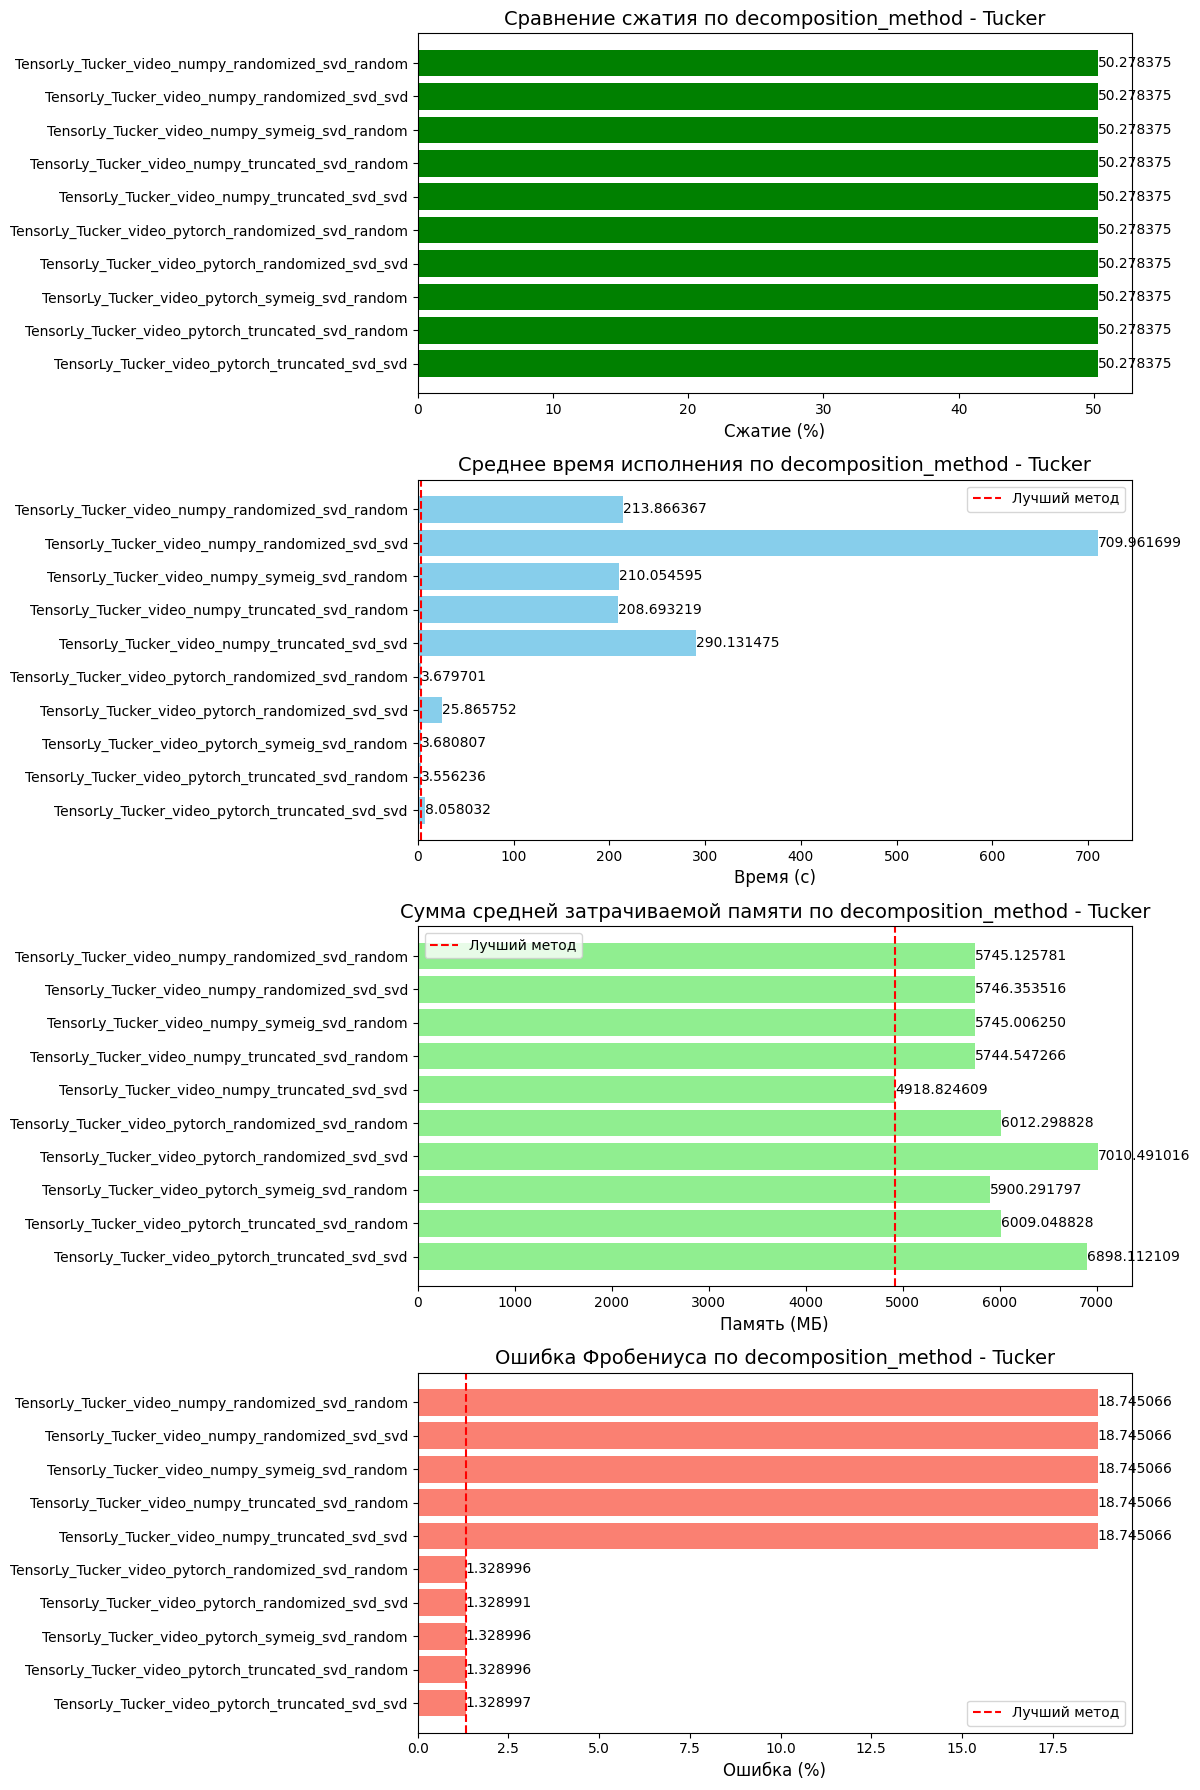

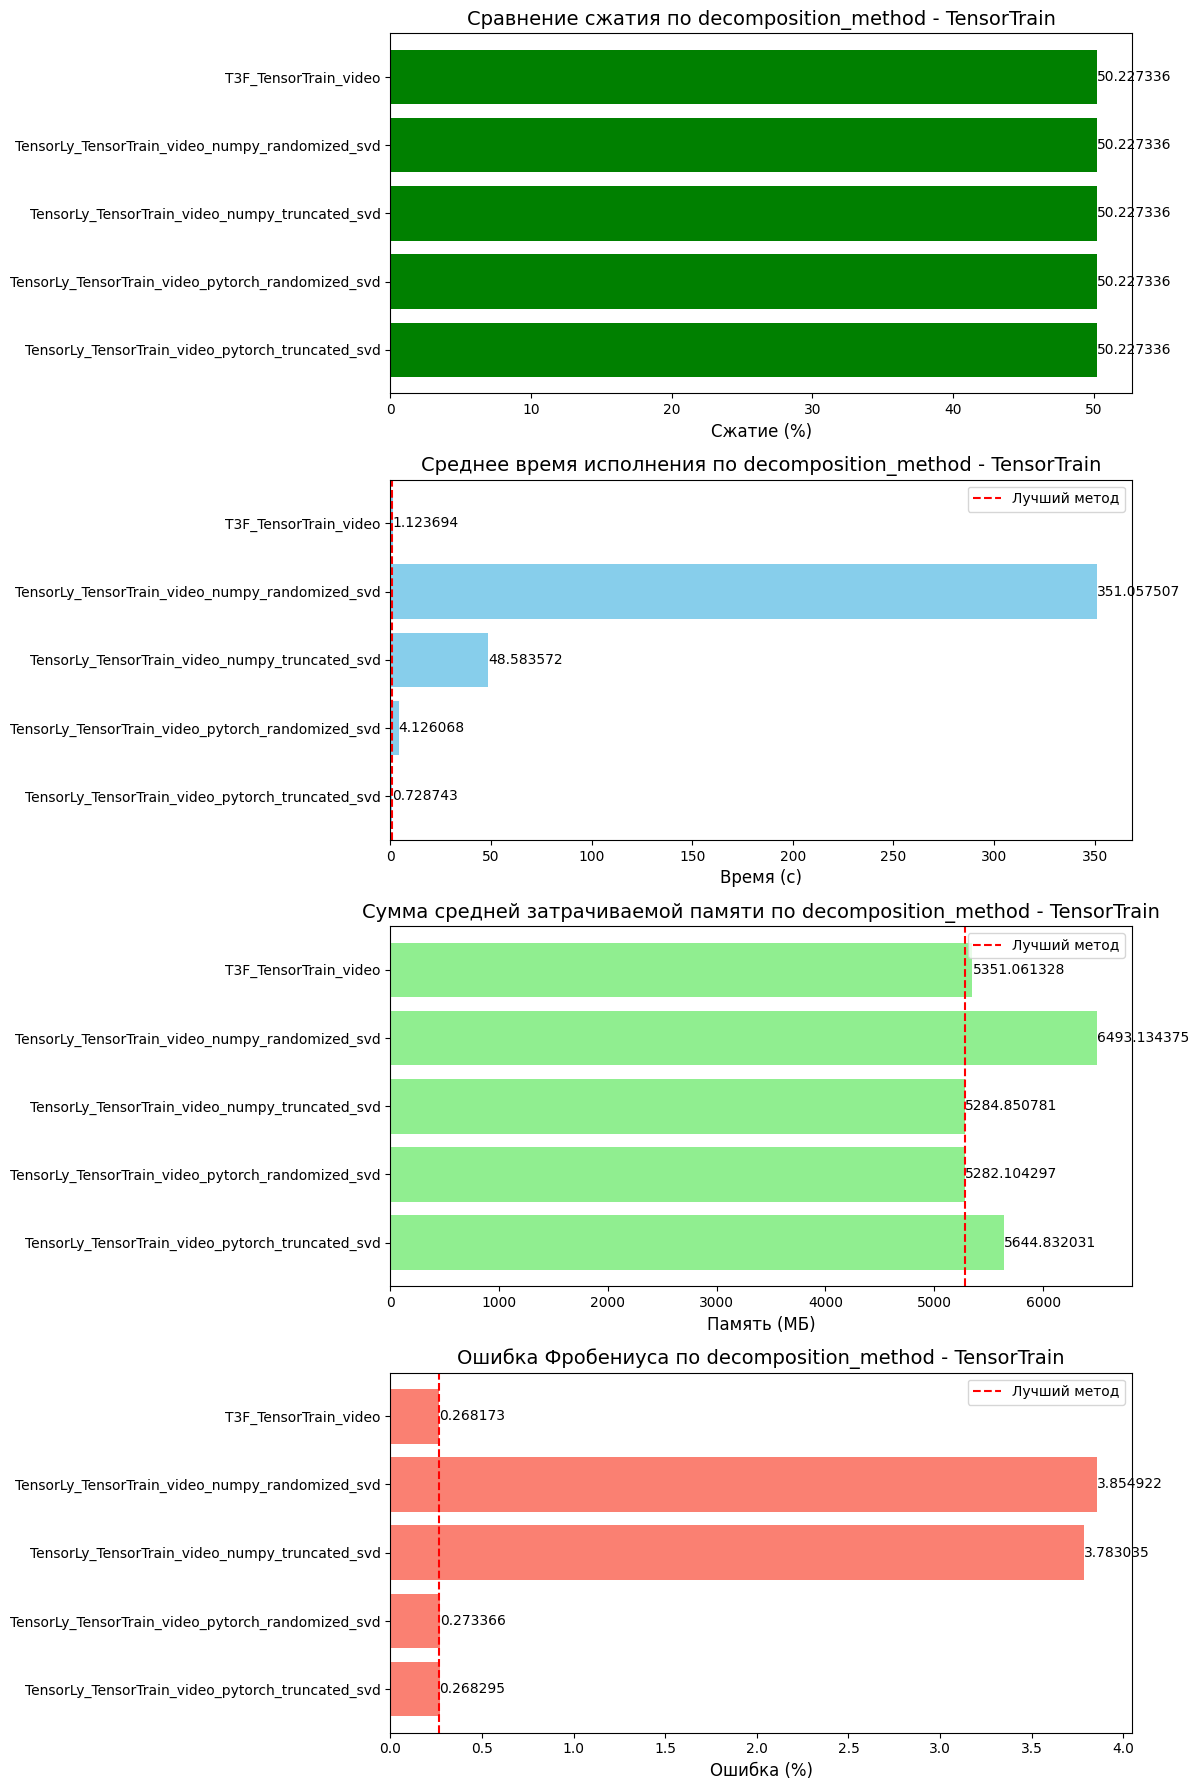

In [121]:
analysis_results_decomposition_method = plot_barhs_and_analyze_dfs(df_logs, group_name="decomposition_method")

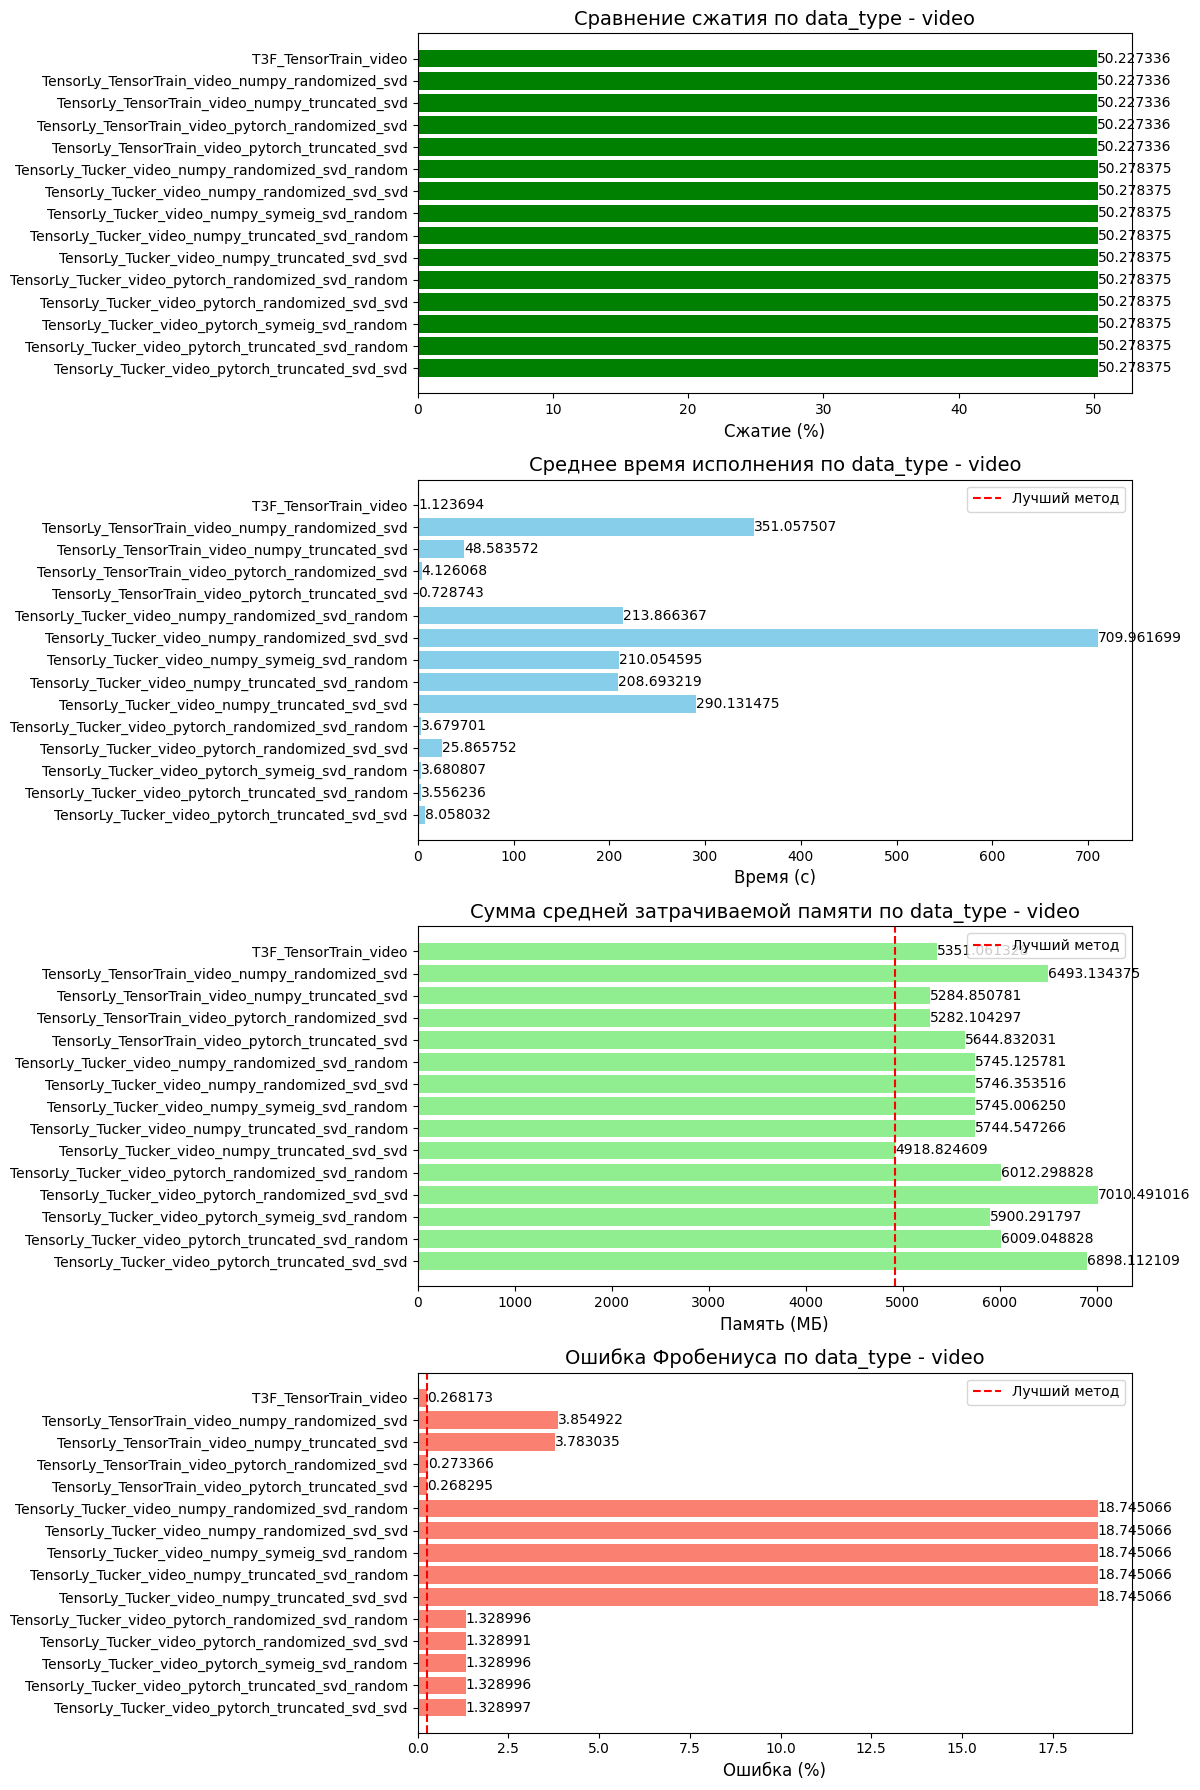

In [122]:
analysis_results_data_type = plot_barhs_and_analyze_dfs(df_logs, group_name="data_type")

In [123]:
pprint(analysis_results_decomposition_method, indent=4, width=100)

{   'TensorTrain': {   'best_error_method': method_name          T3F_TensorTrain_video
average_time                      1.123694
total_memory                   5351.061328
frobenius_error                   0.268173
compression_ratio                50.227336
Name: 4, dtype: object,
                       'best_memory_method': method_name          TensorLy_TensorTrain_video_pytorch_randomized_svd
average_time                                                  4.126068
total_memory                                               5282.104297
frobenius_error                                               0.273366
compression_ratio                                            50.227336
Name: 1, dtype: object,
                       'best_time_method': method_name          TensorLy_TensorTrain_video_pytorch_truncated_svd
average_time                                                 0.728743
total_memory                                              5644.832031
frobenius_error                         

In [124]:
pprint(analysis_results_data_type, indent=4, width=100)

{   'video': {   'best_error_method': method_name          T3F_TensorTrain_video
average_time                      1.123694
total_memory                   5351.061328
frobenius_error                   0.268173
compression_ratio                50.227336
Name: 14, dtype: object,
                 'best_memory_method': method_name          TensorLy_Tucker_video_numpy_truncated_svd_svd
average_time                                            290.131475
total_memory                                           4918.824609
frobenius_error                                          18.745066
compression_ratio                                        50.278375
Name: 5, dtype: object,
                 'best_time_method': method_name          TensorLy_TensorTrain_video_pytorch_truncated_svd
average_time                                                 0.728743
total_memory                                              5644.832031
frobenius_error                                              0.268295
compres

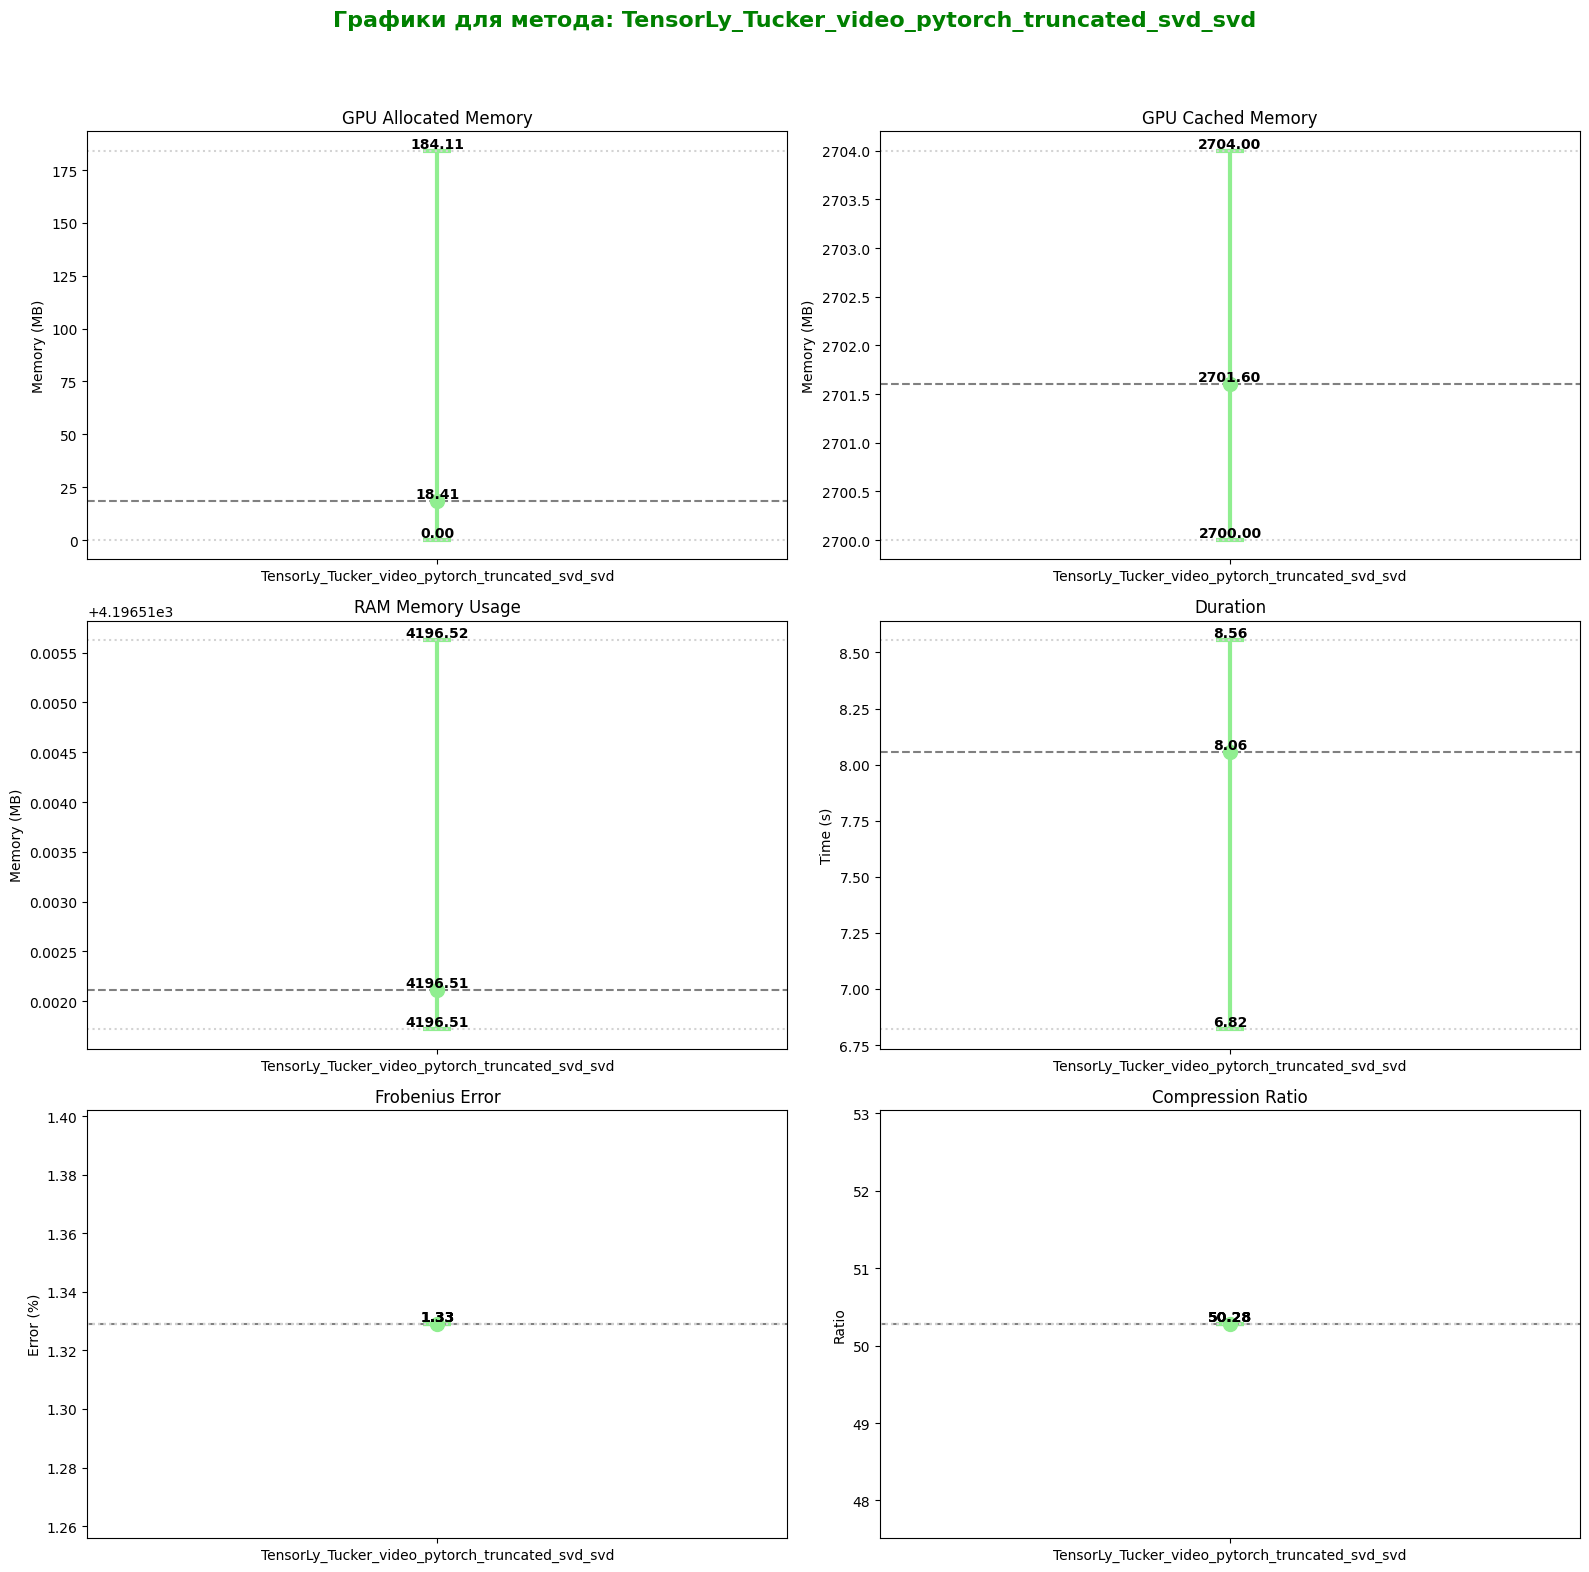

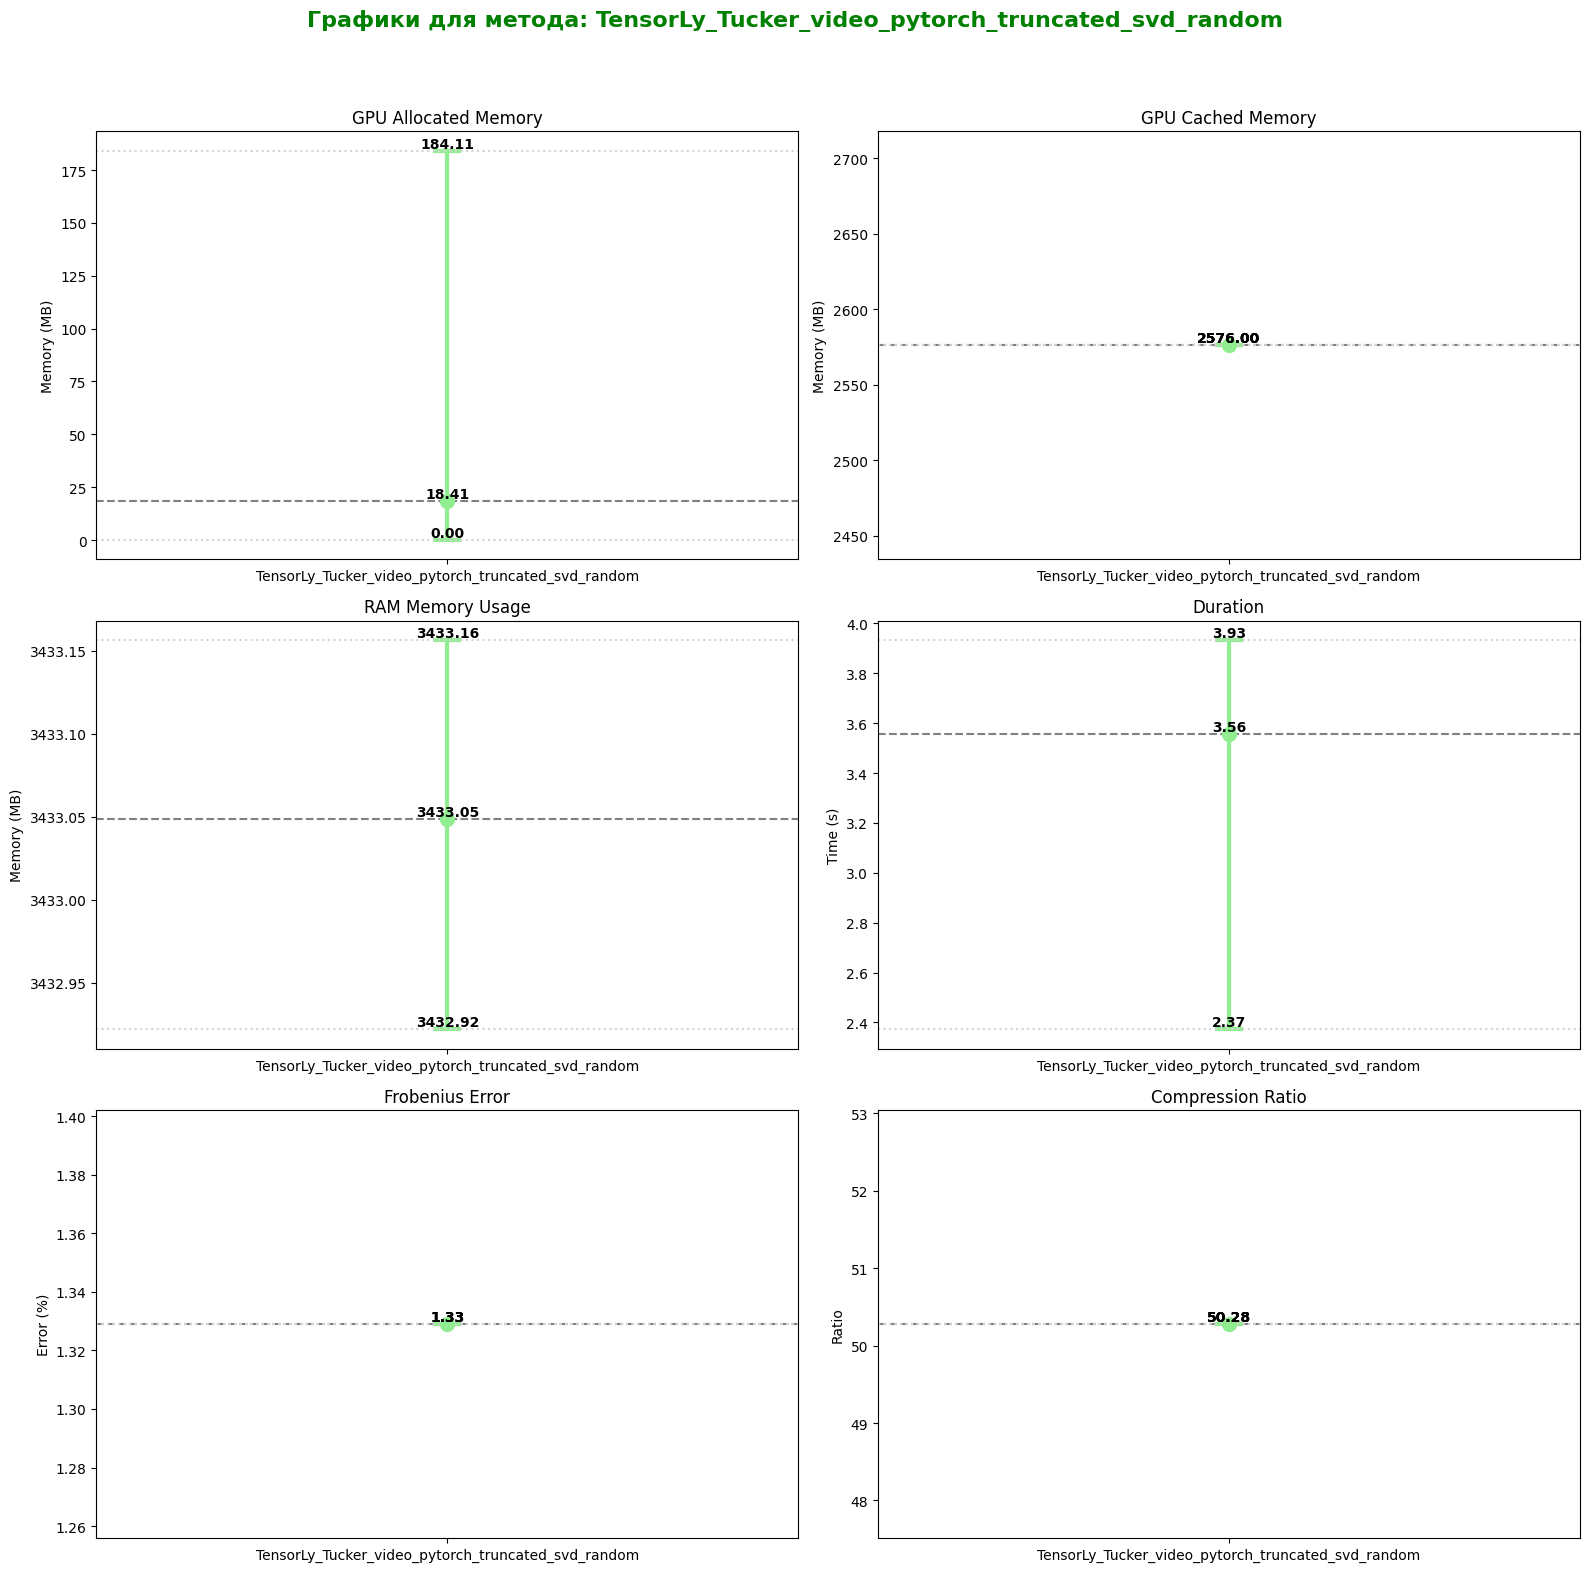

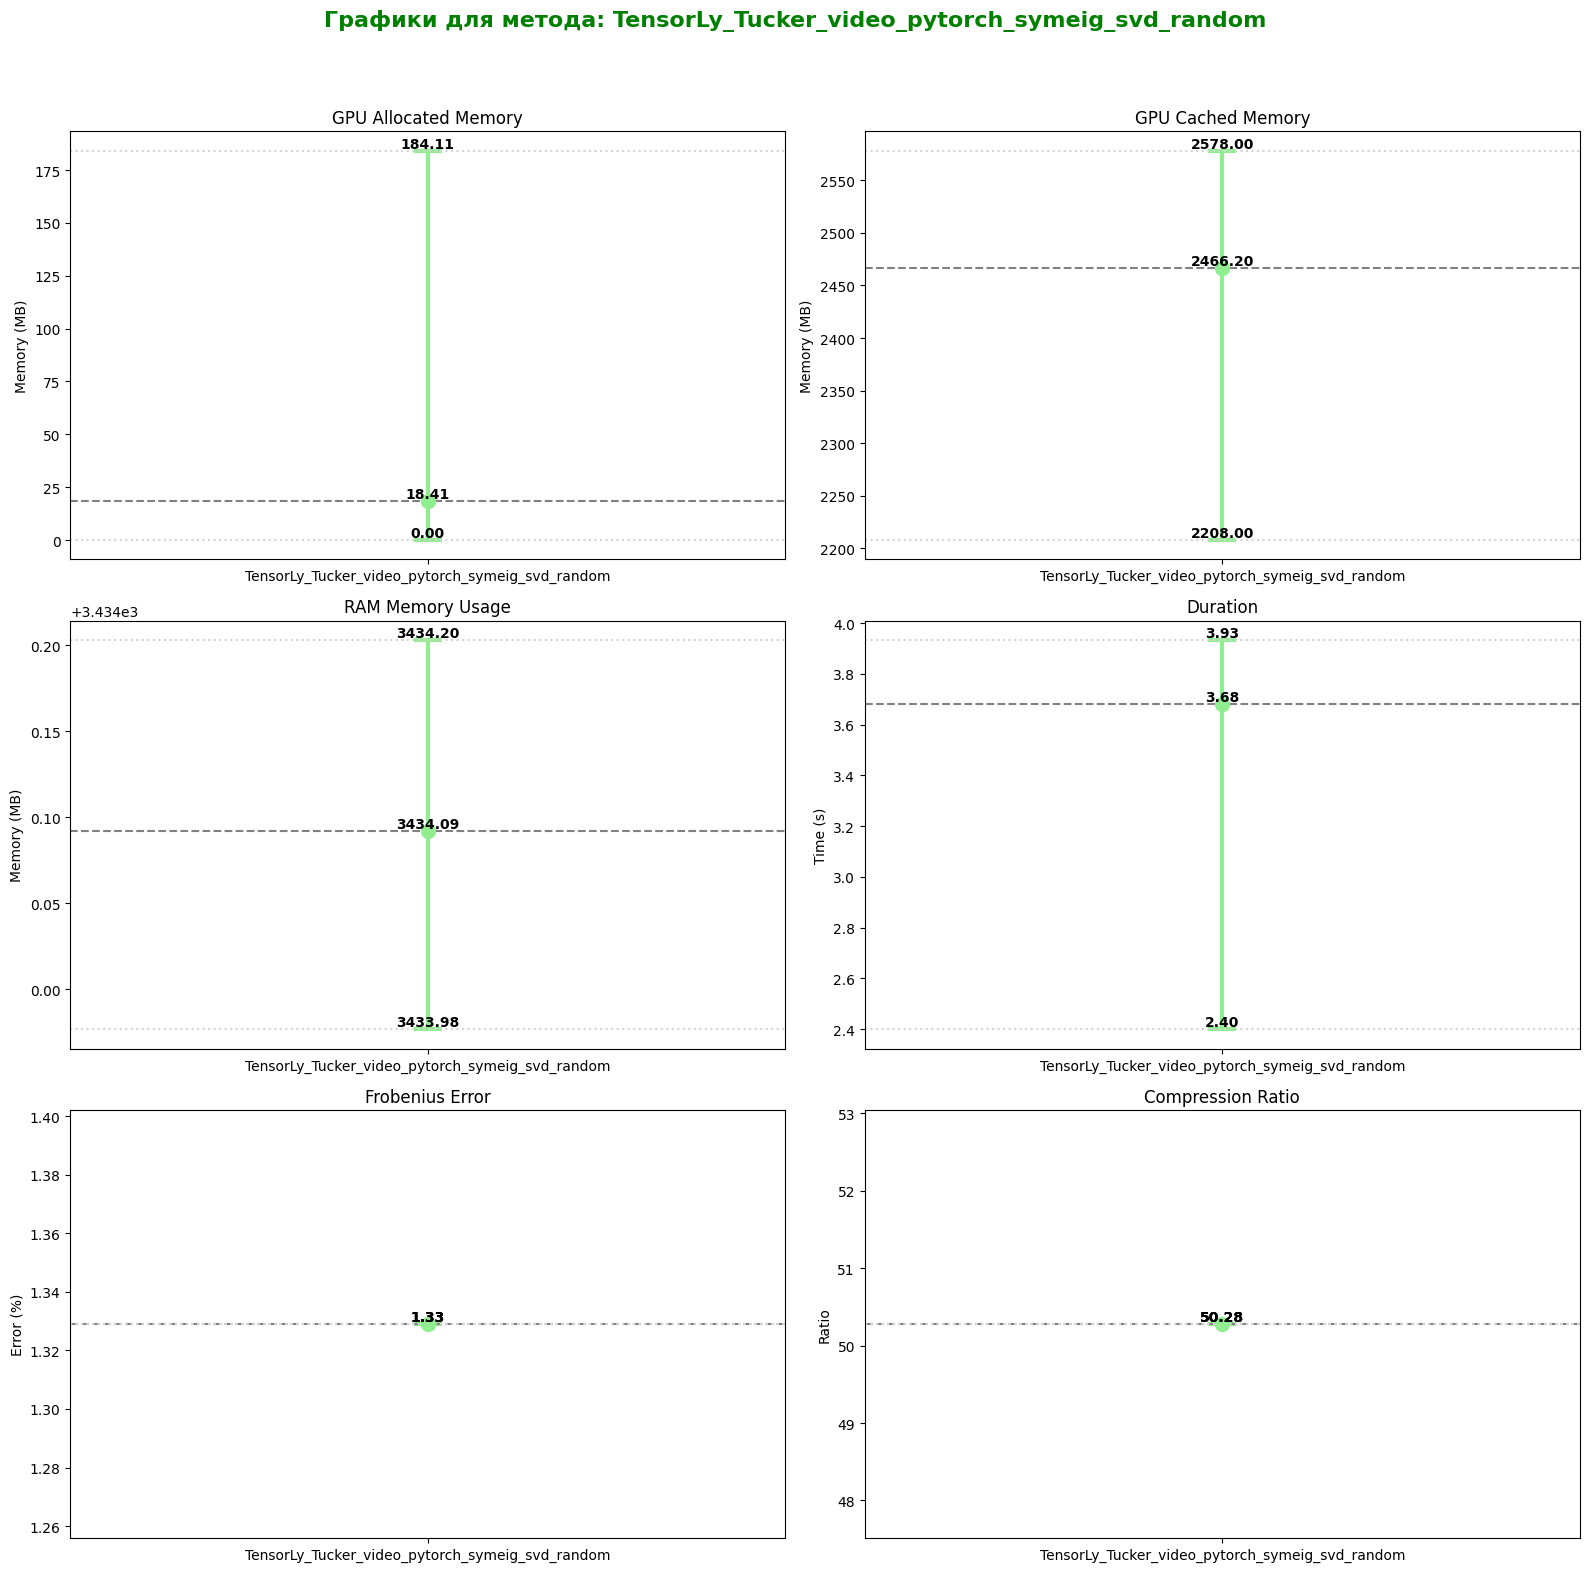

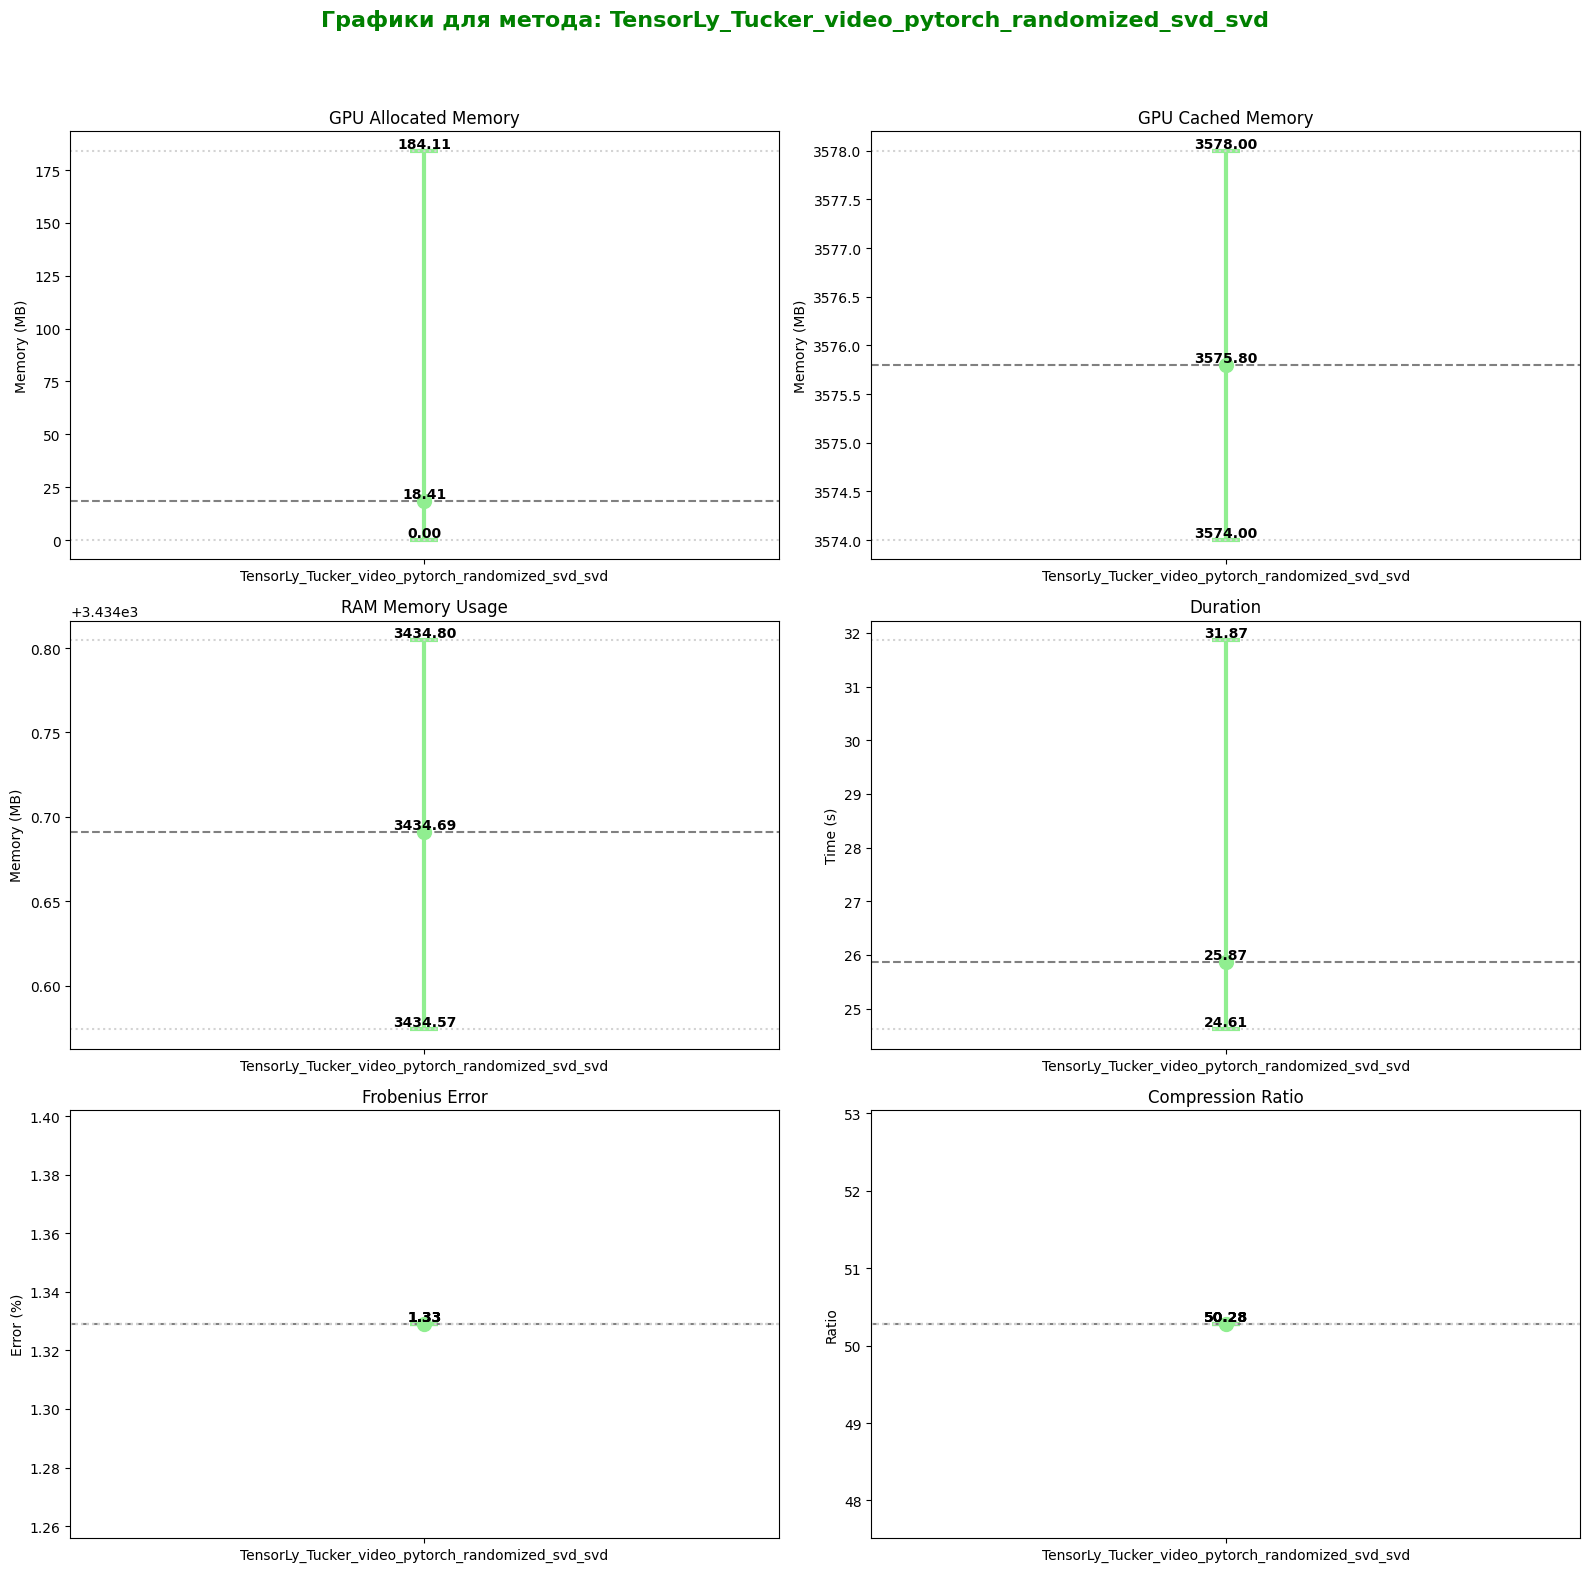

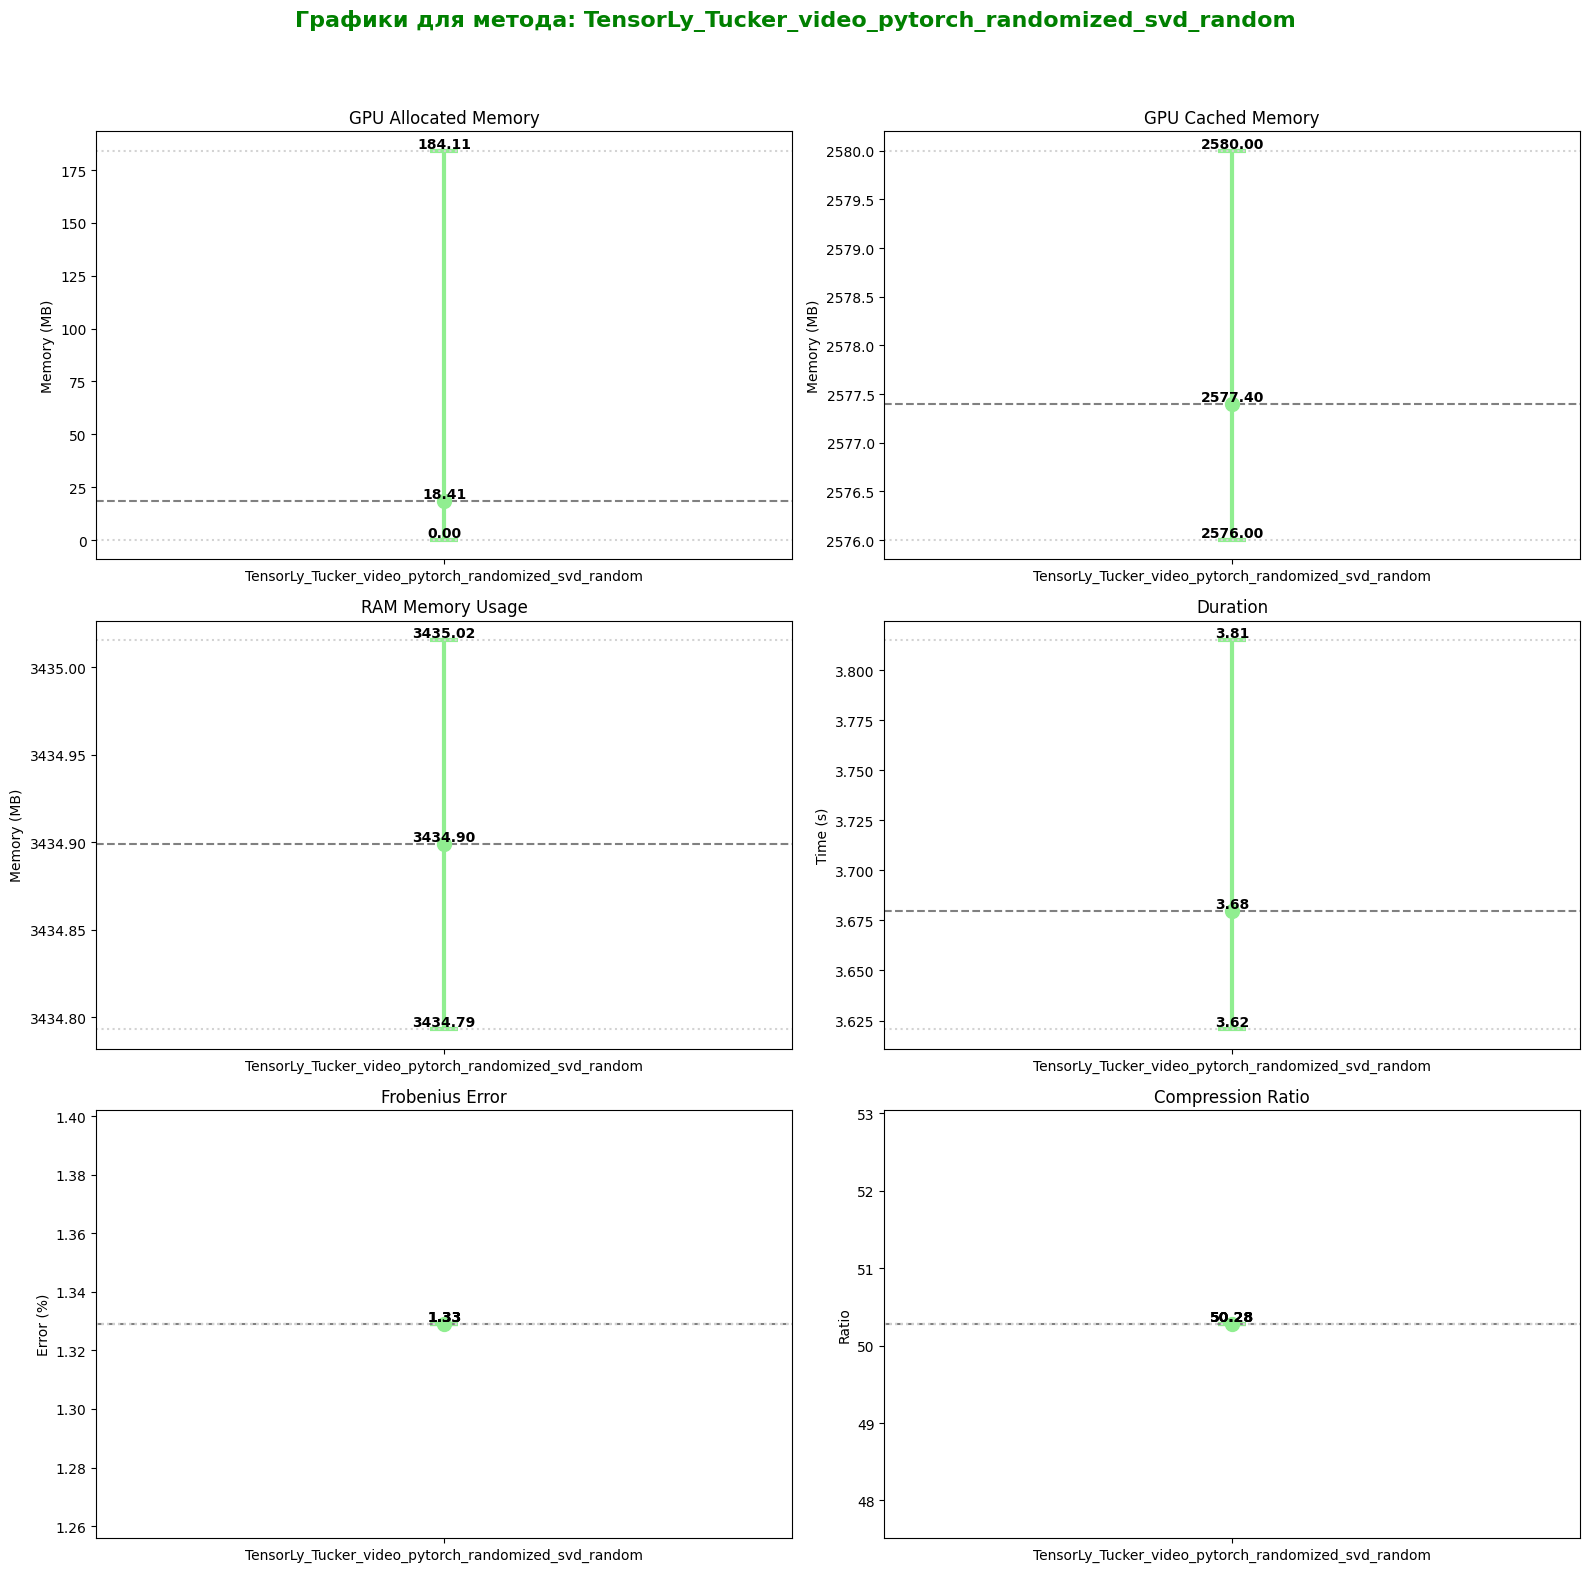

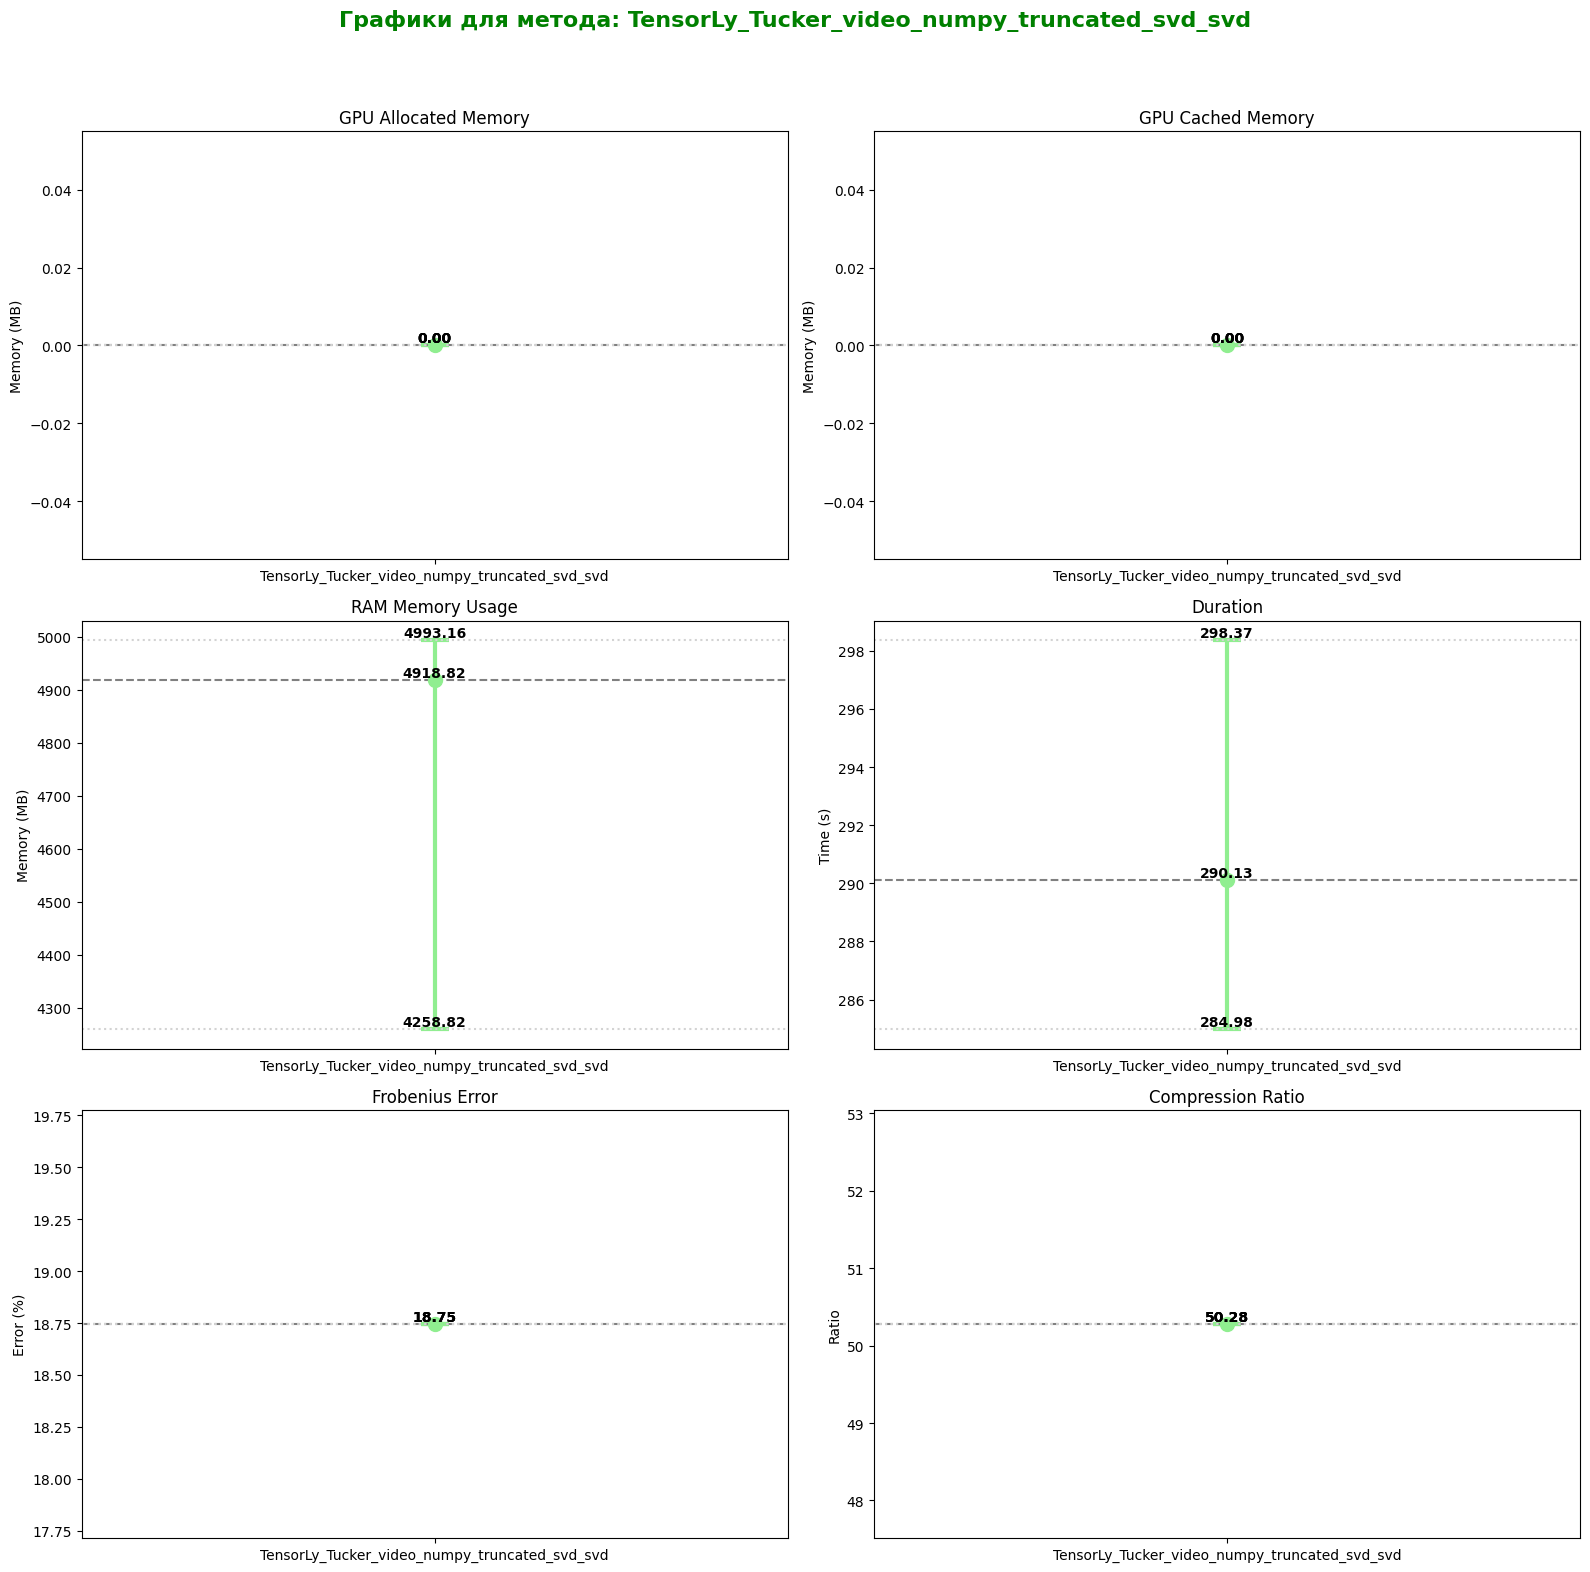

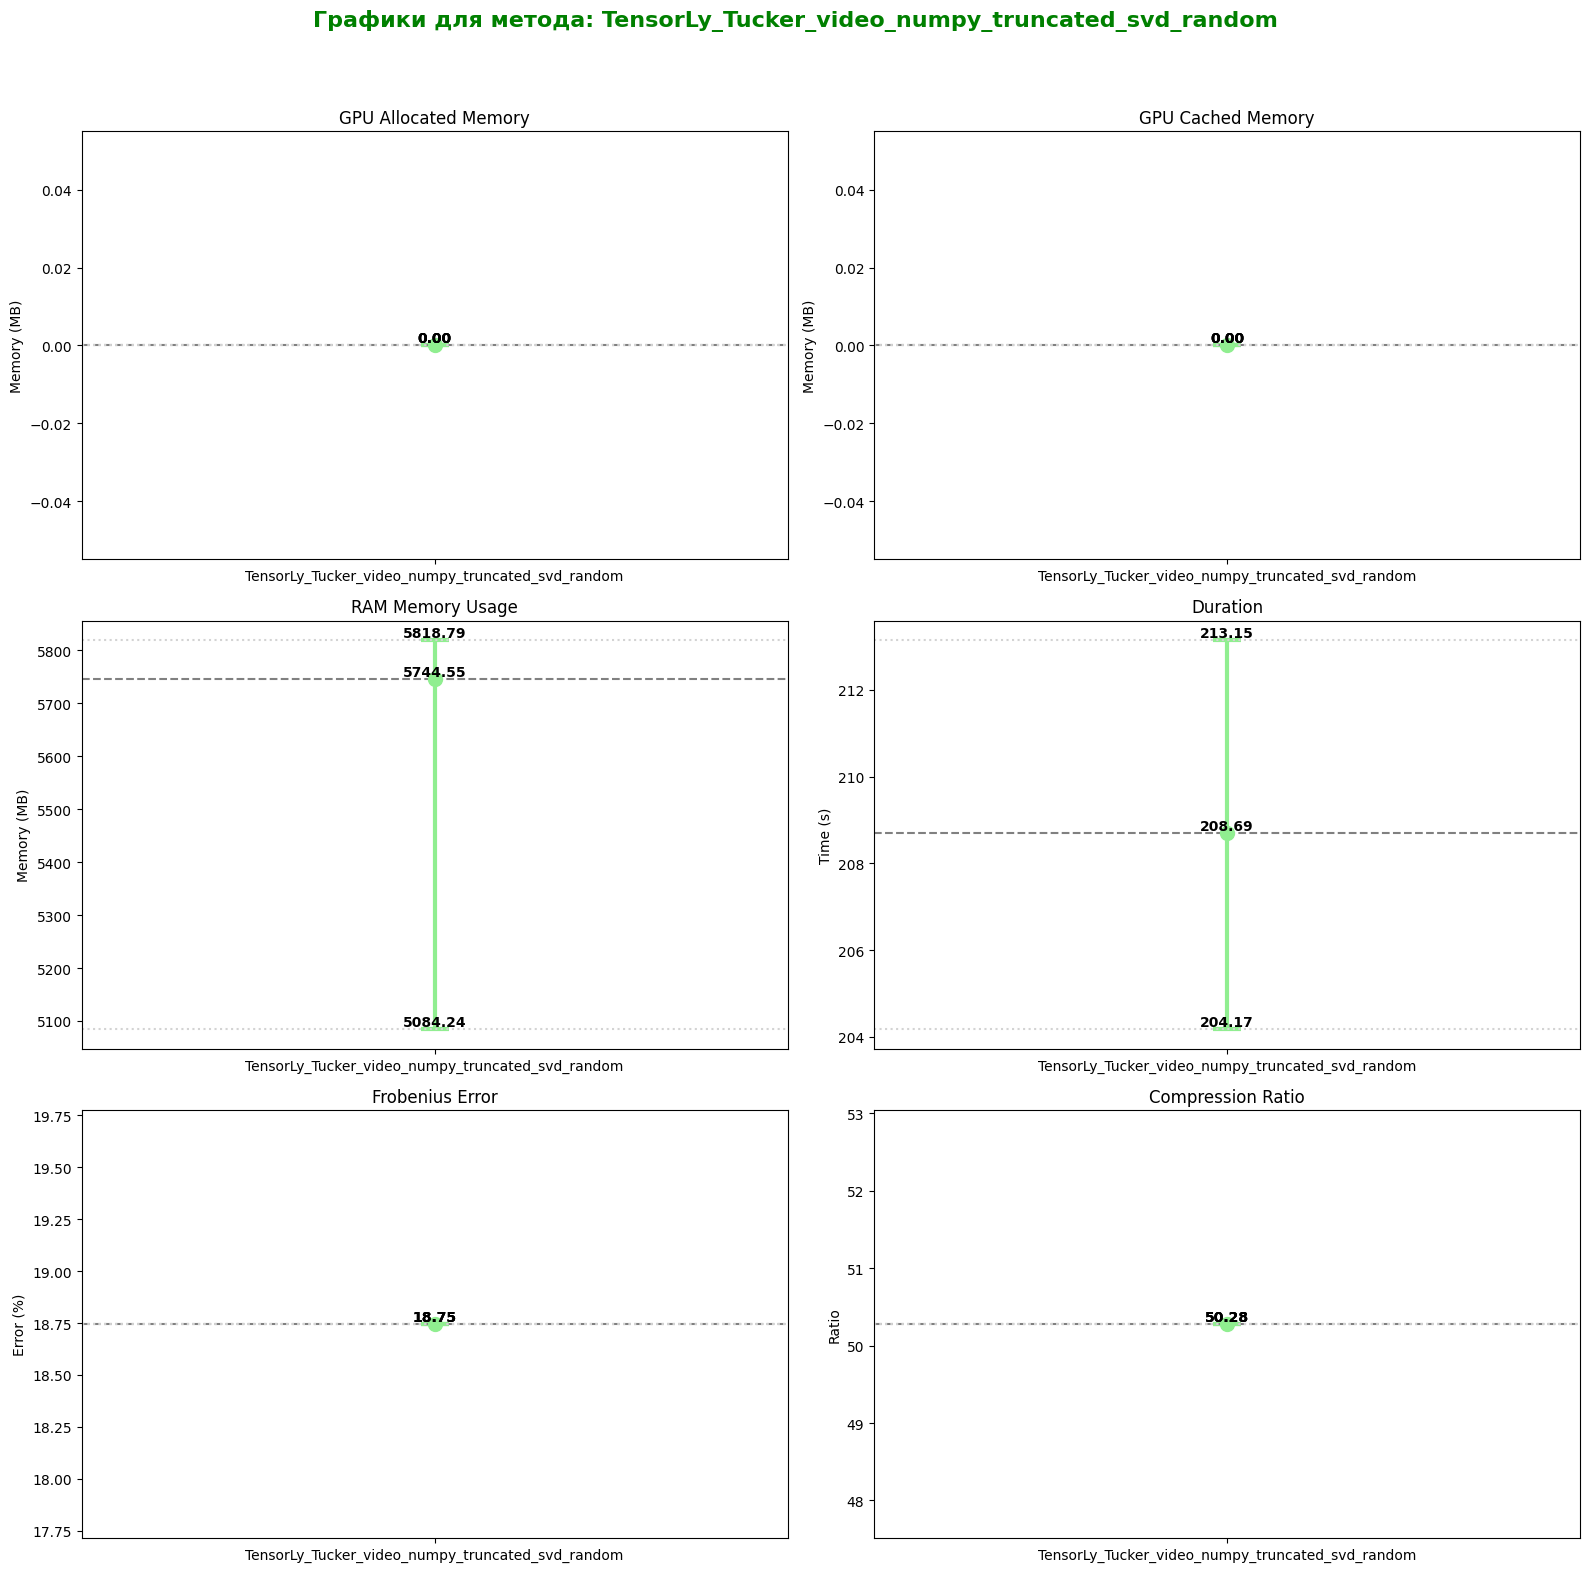

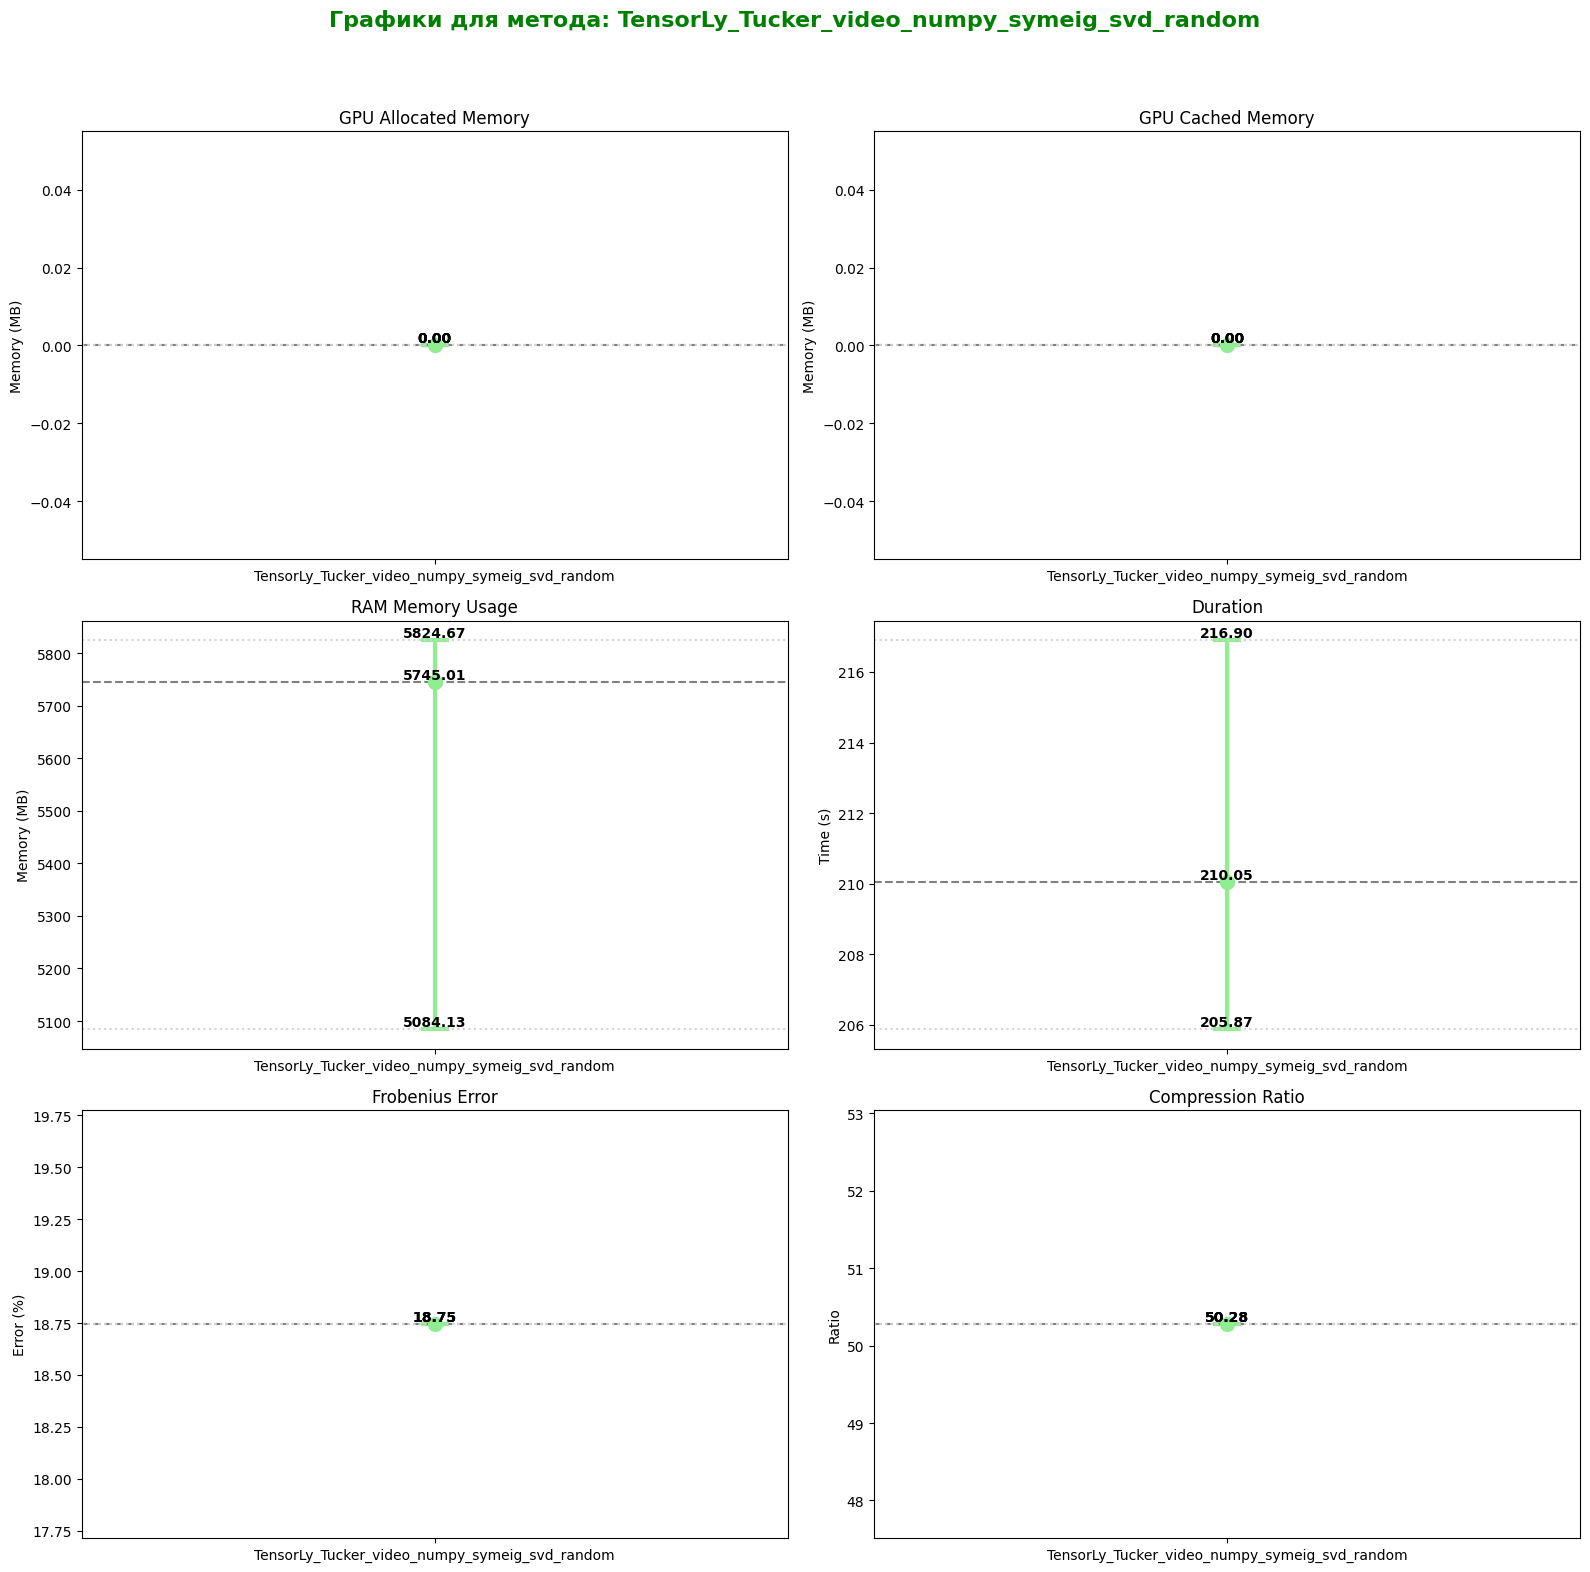

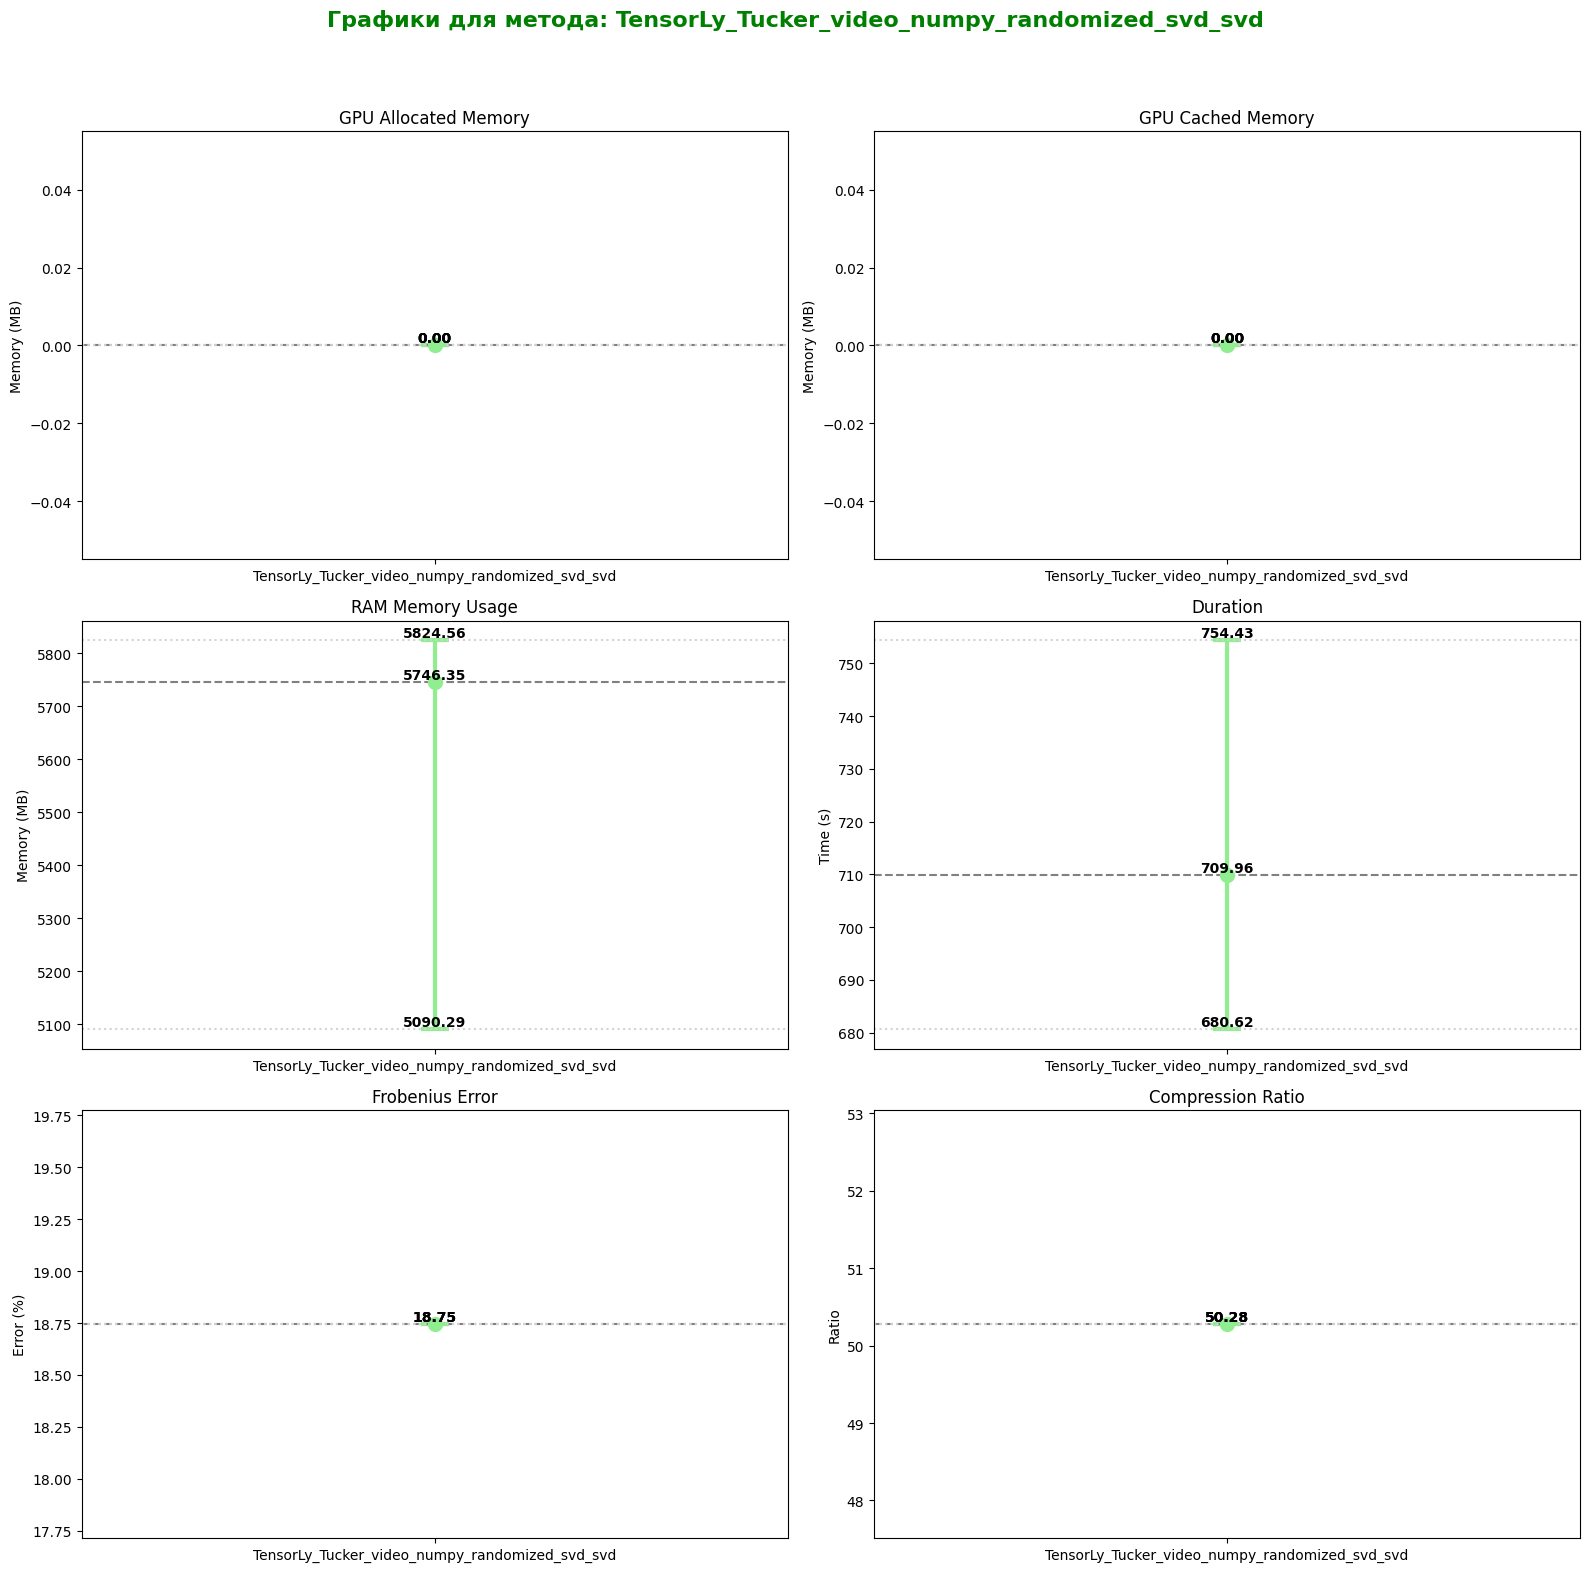

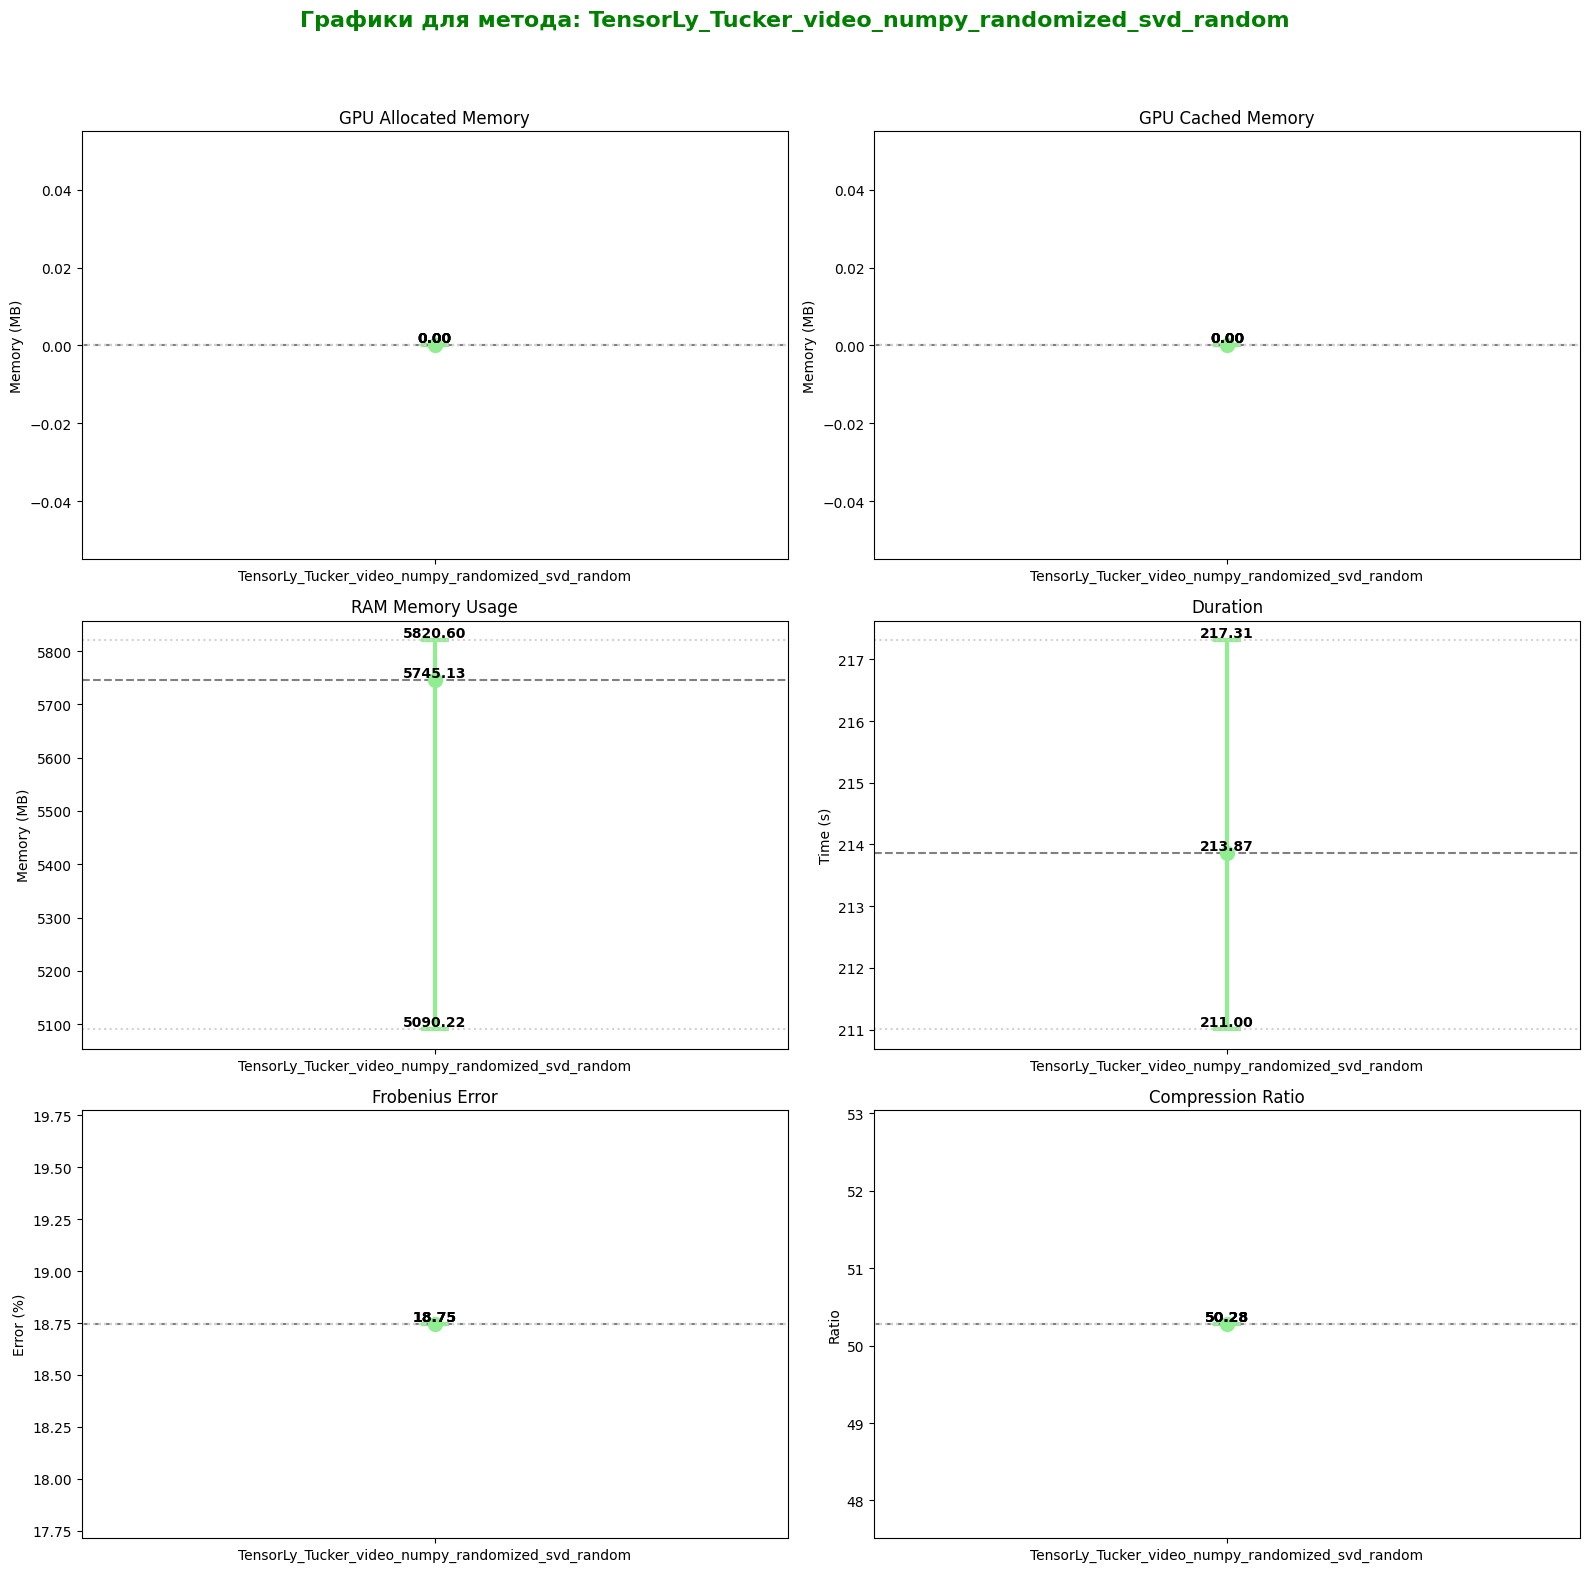

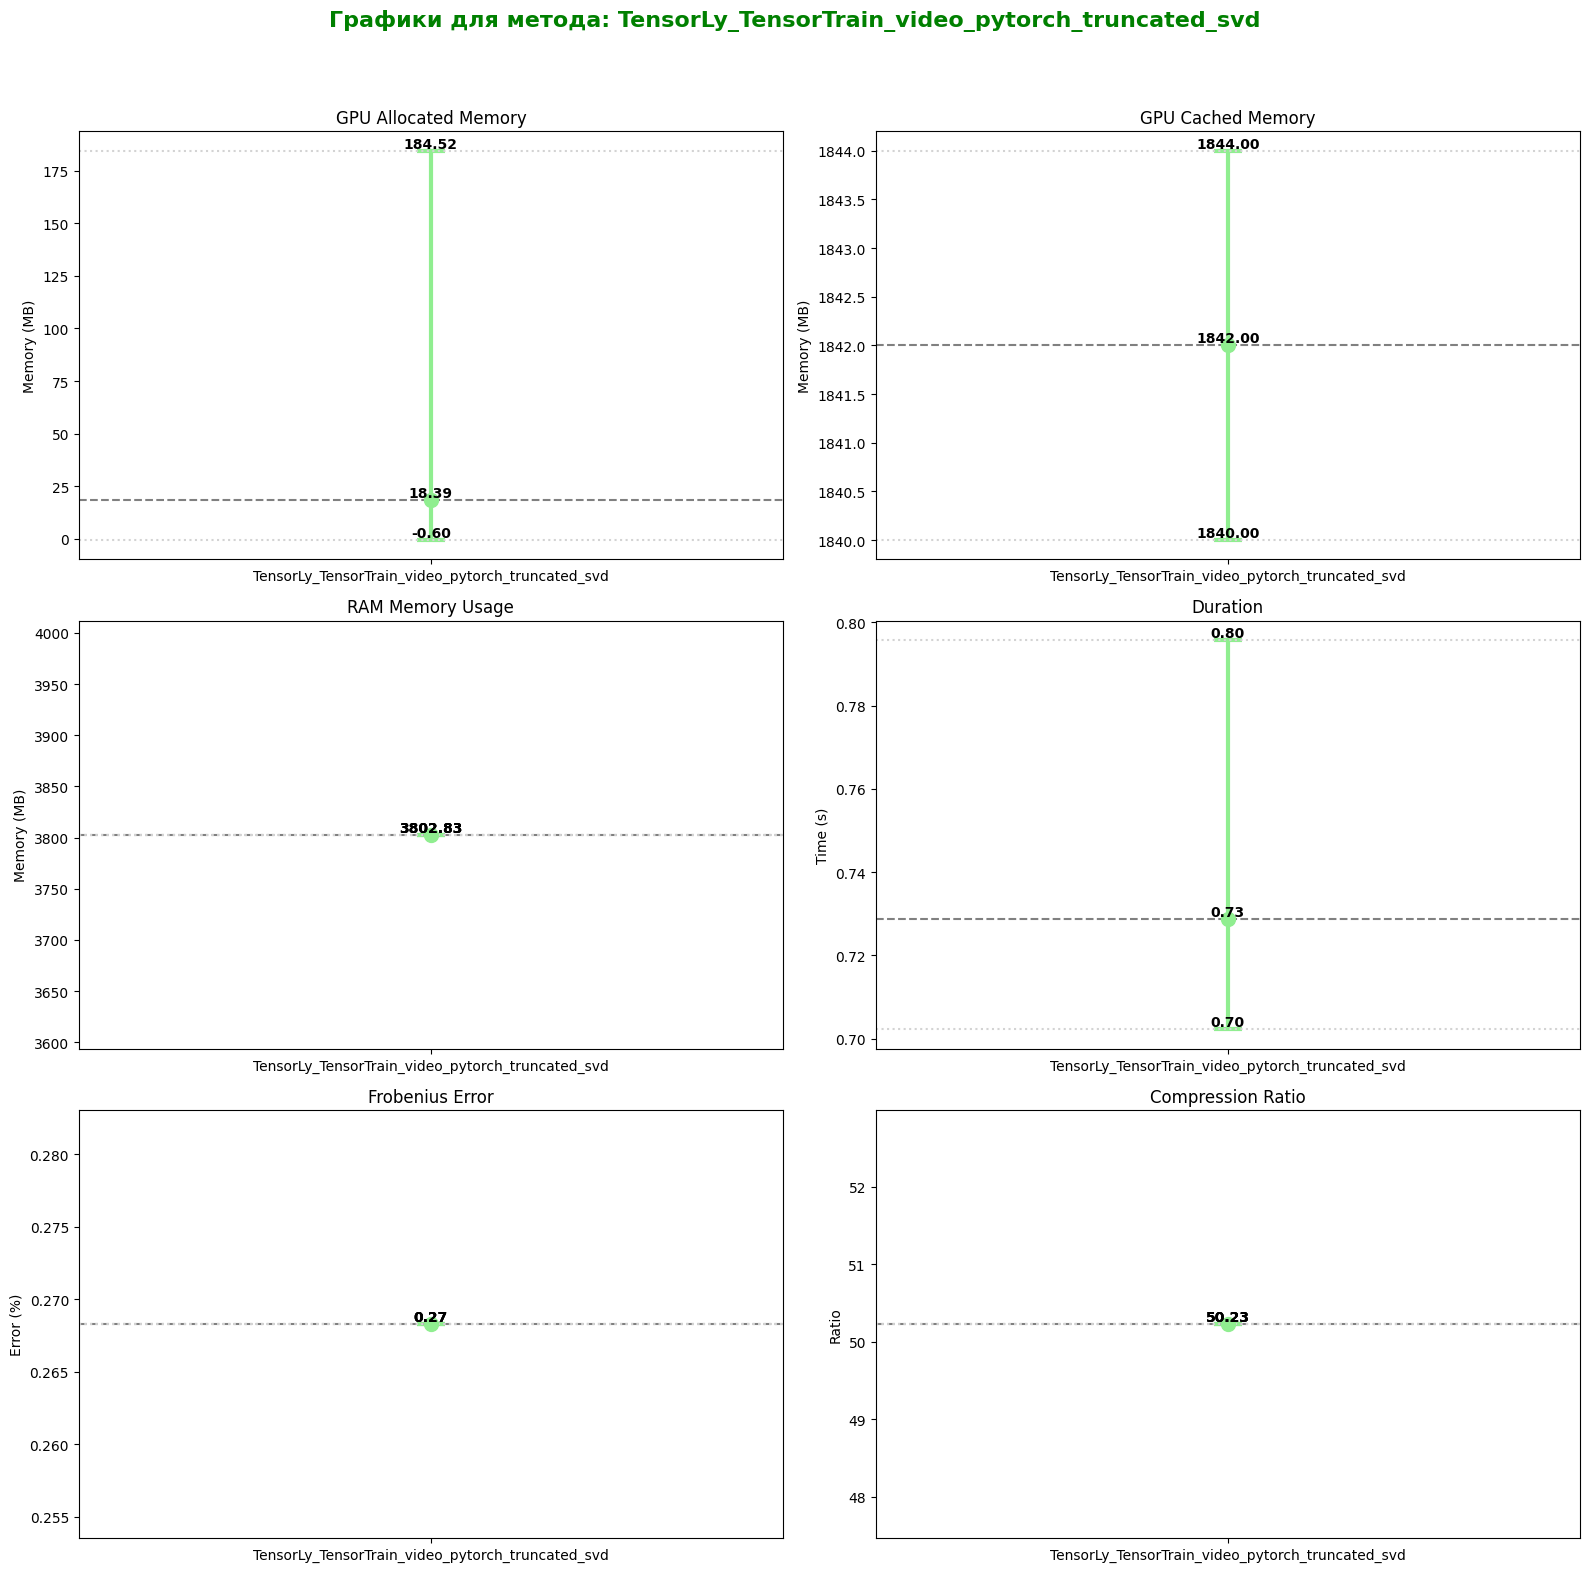

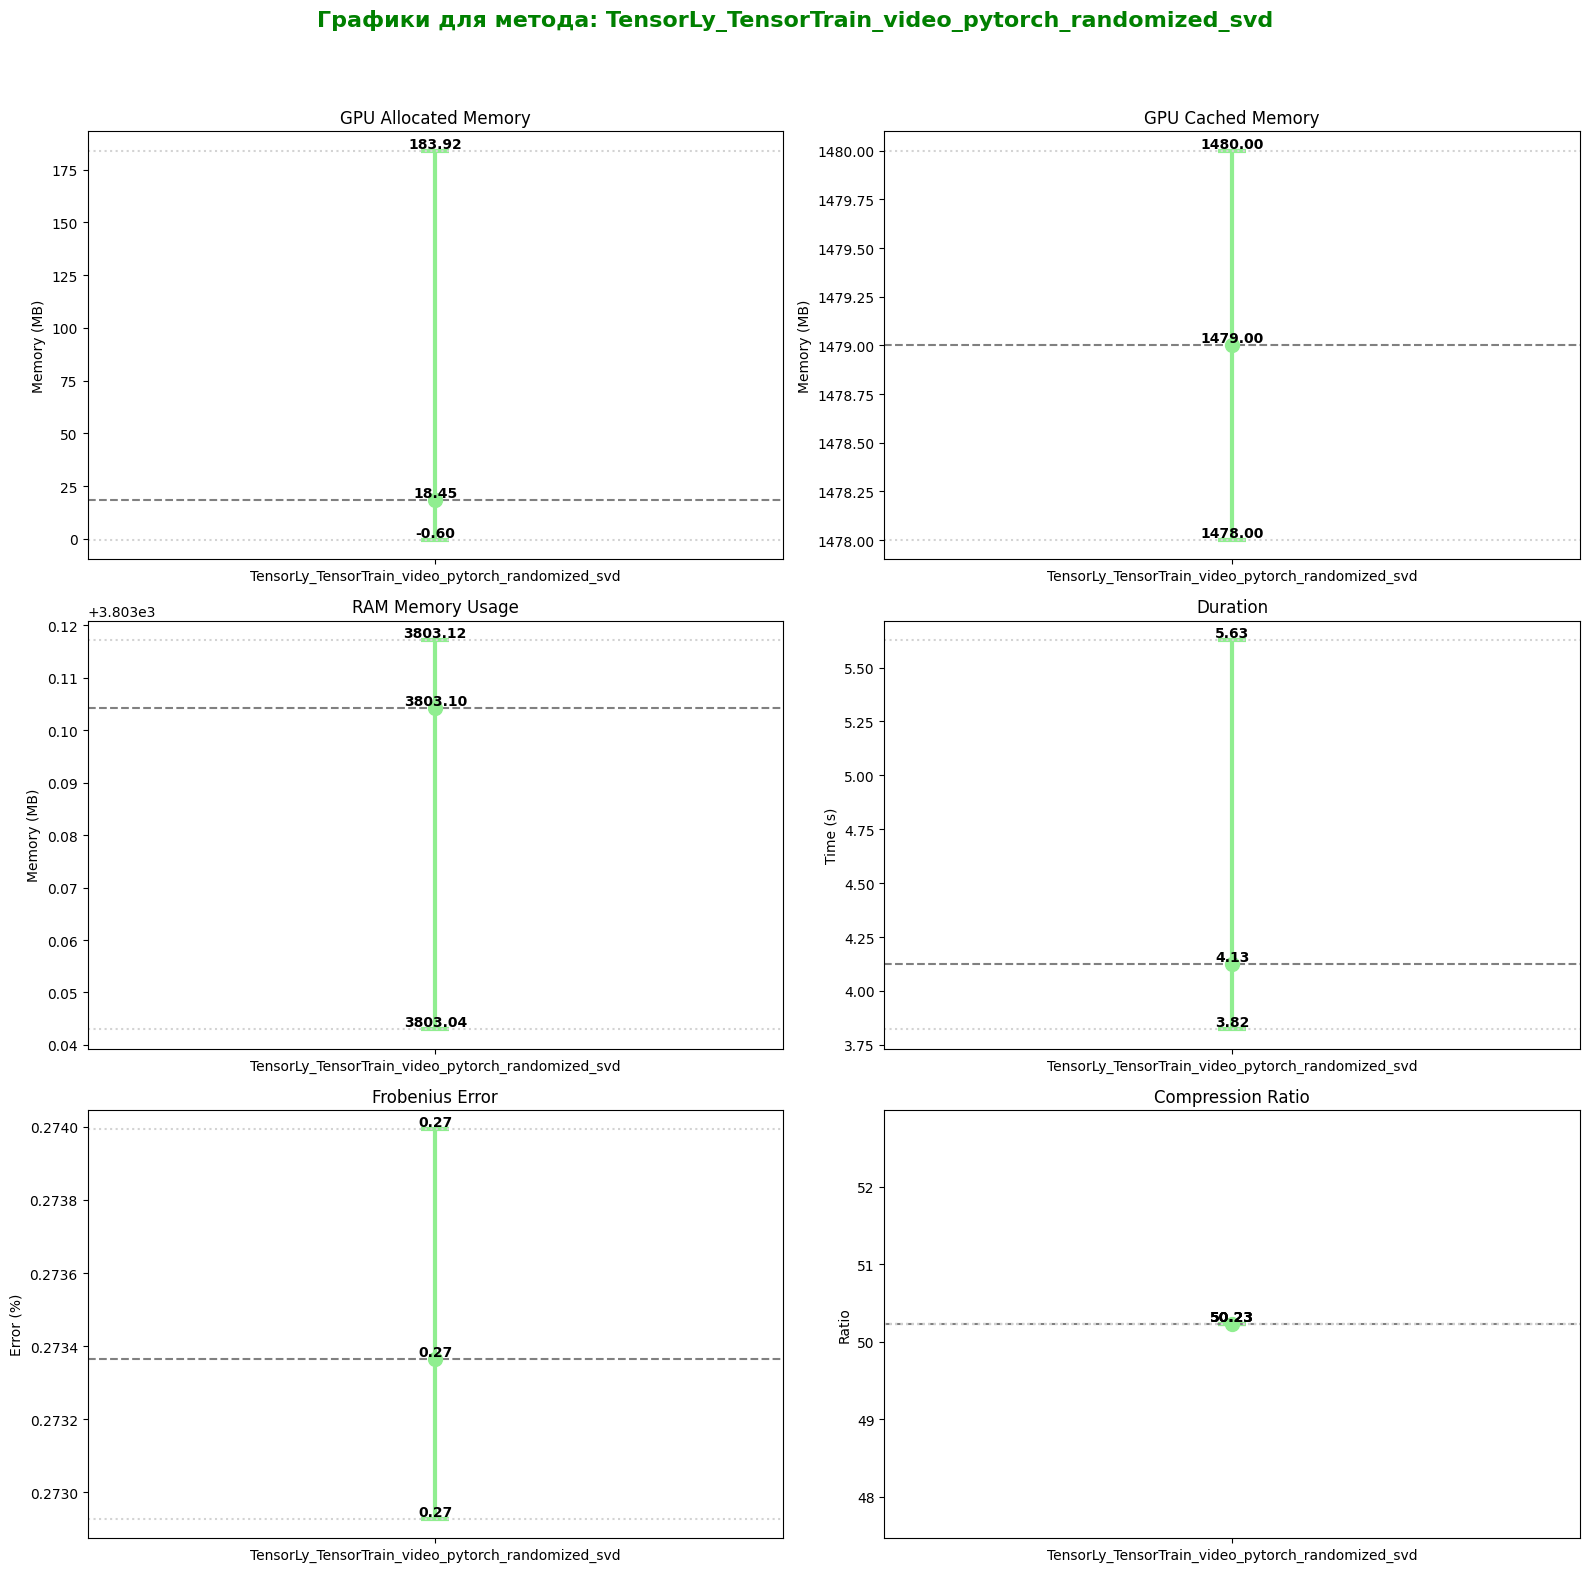

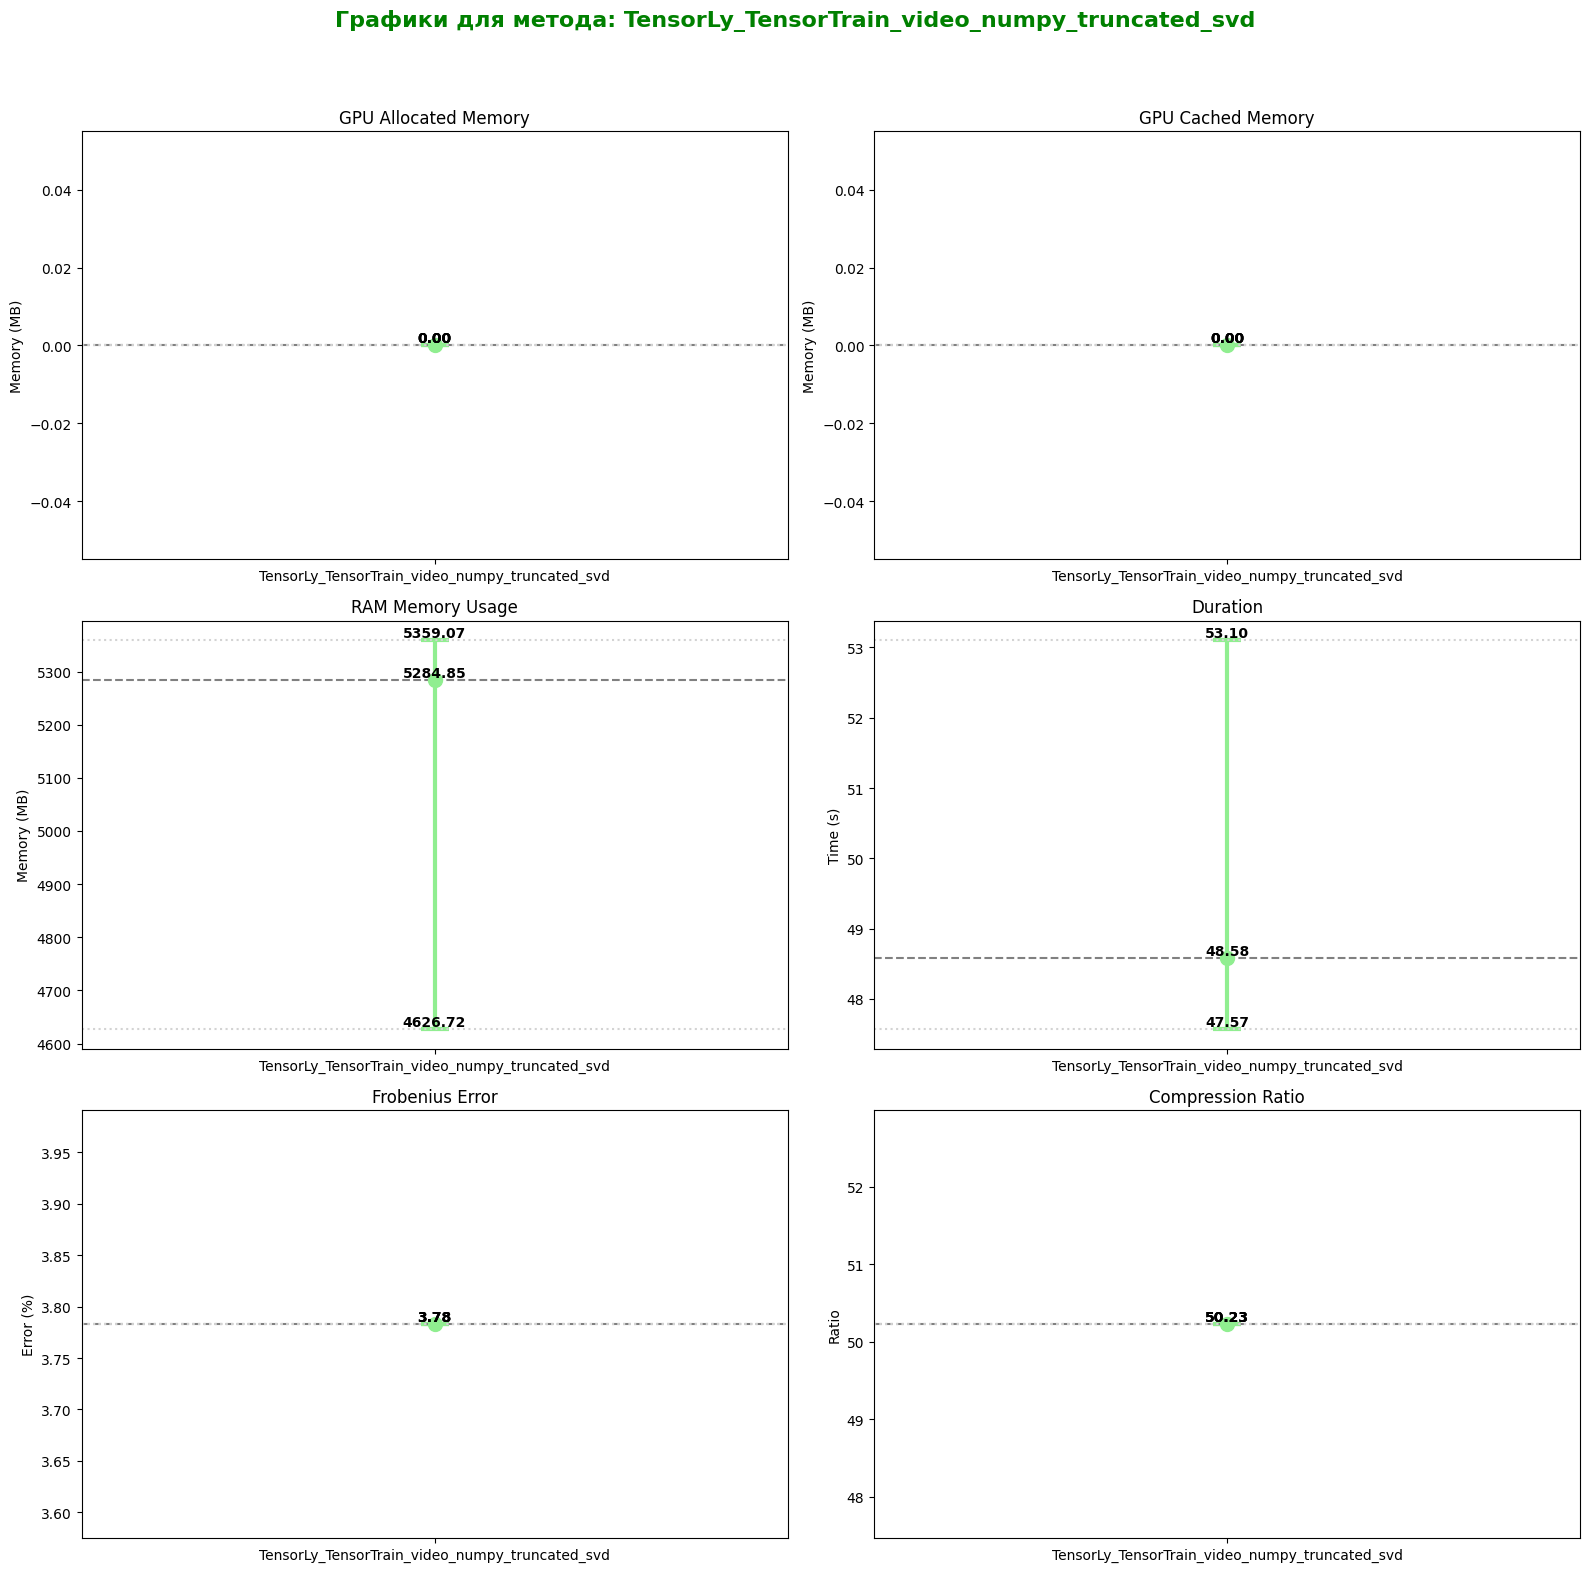

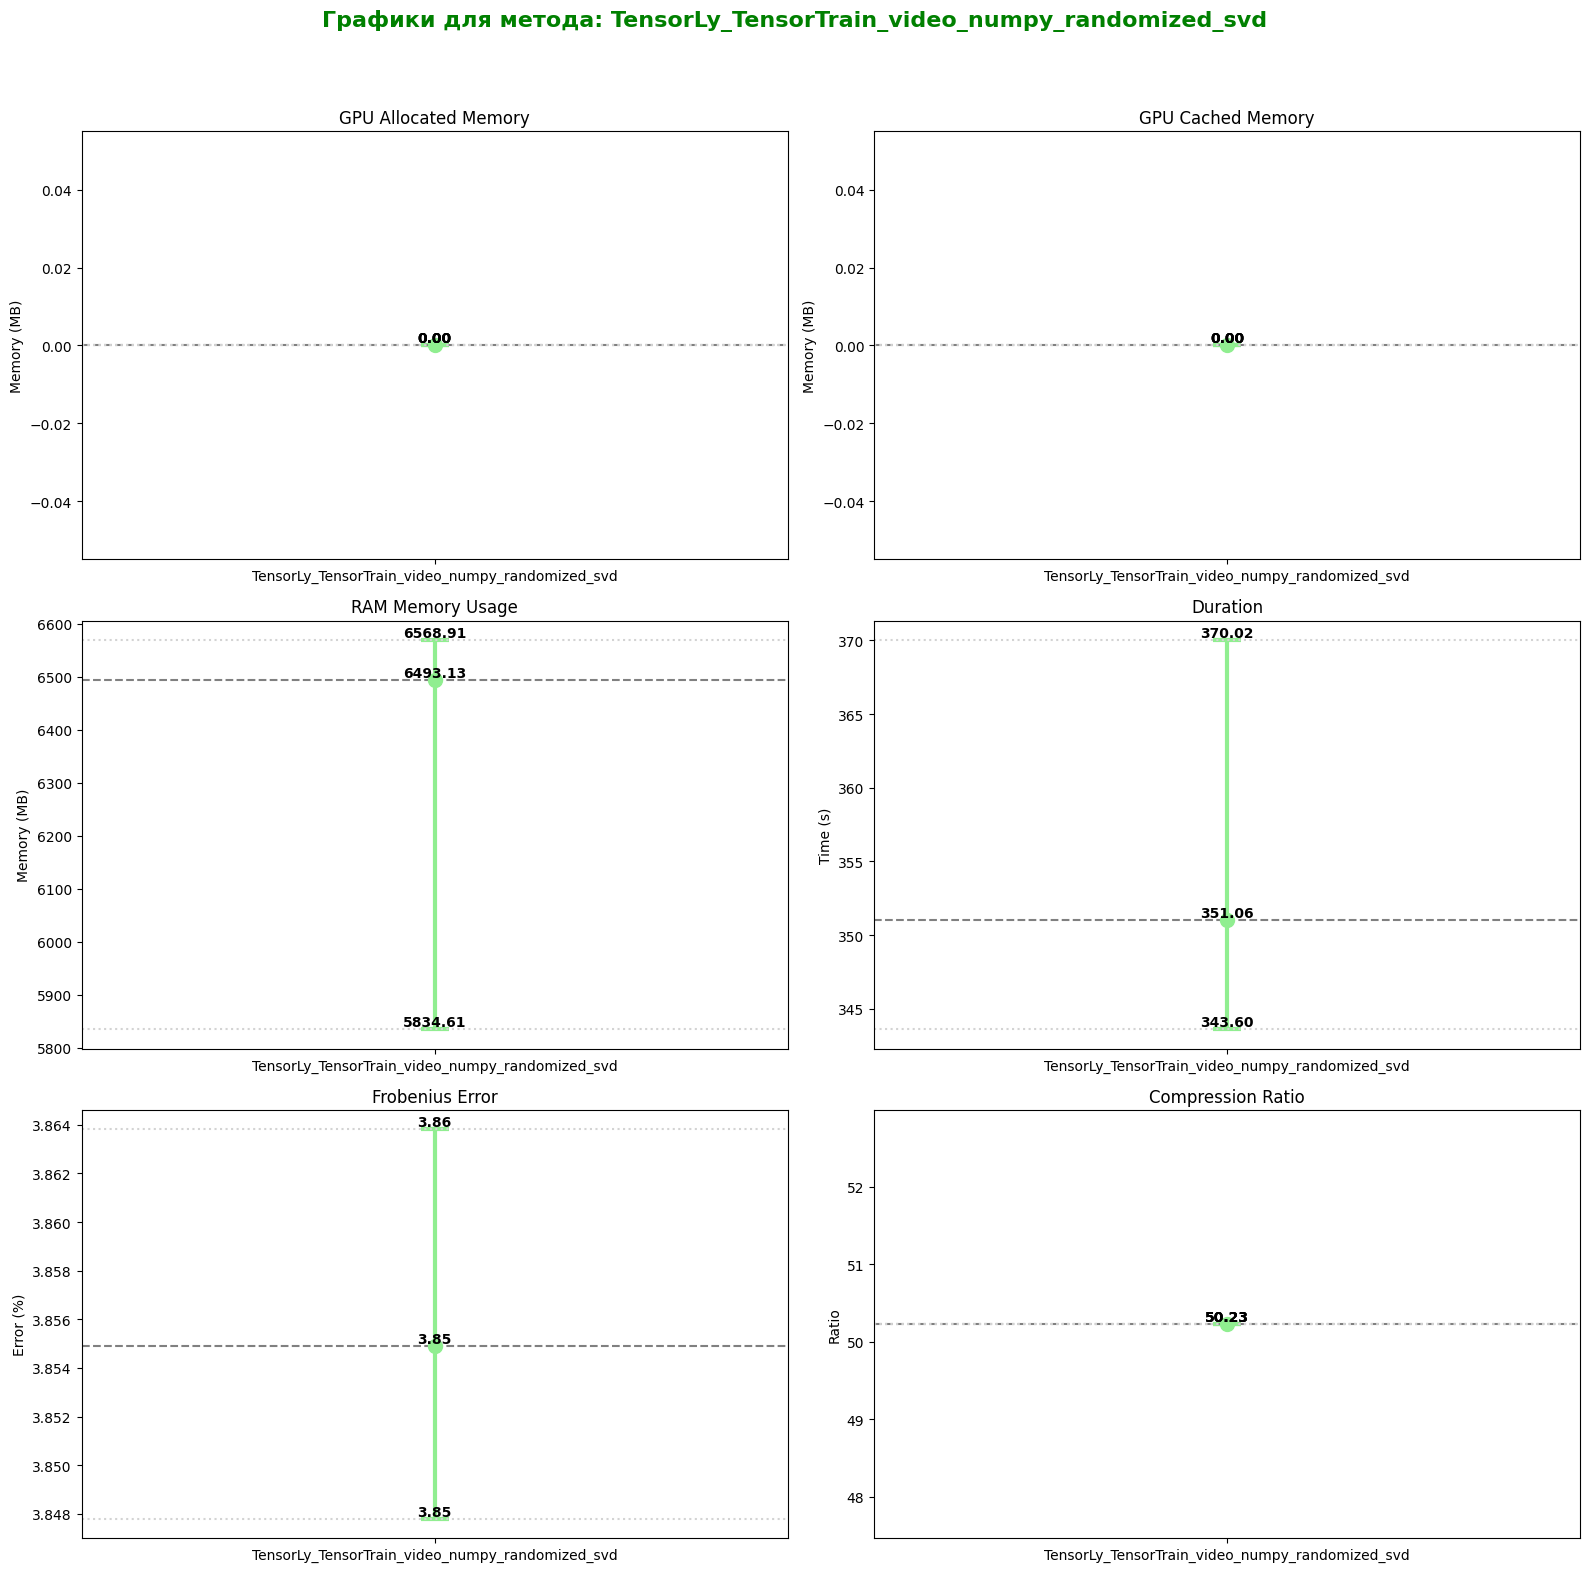

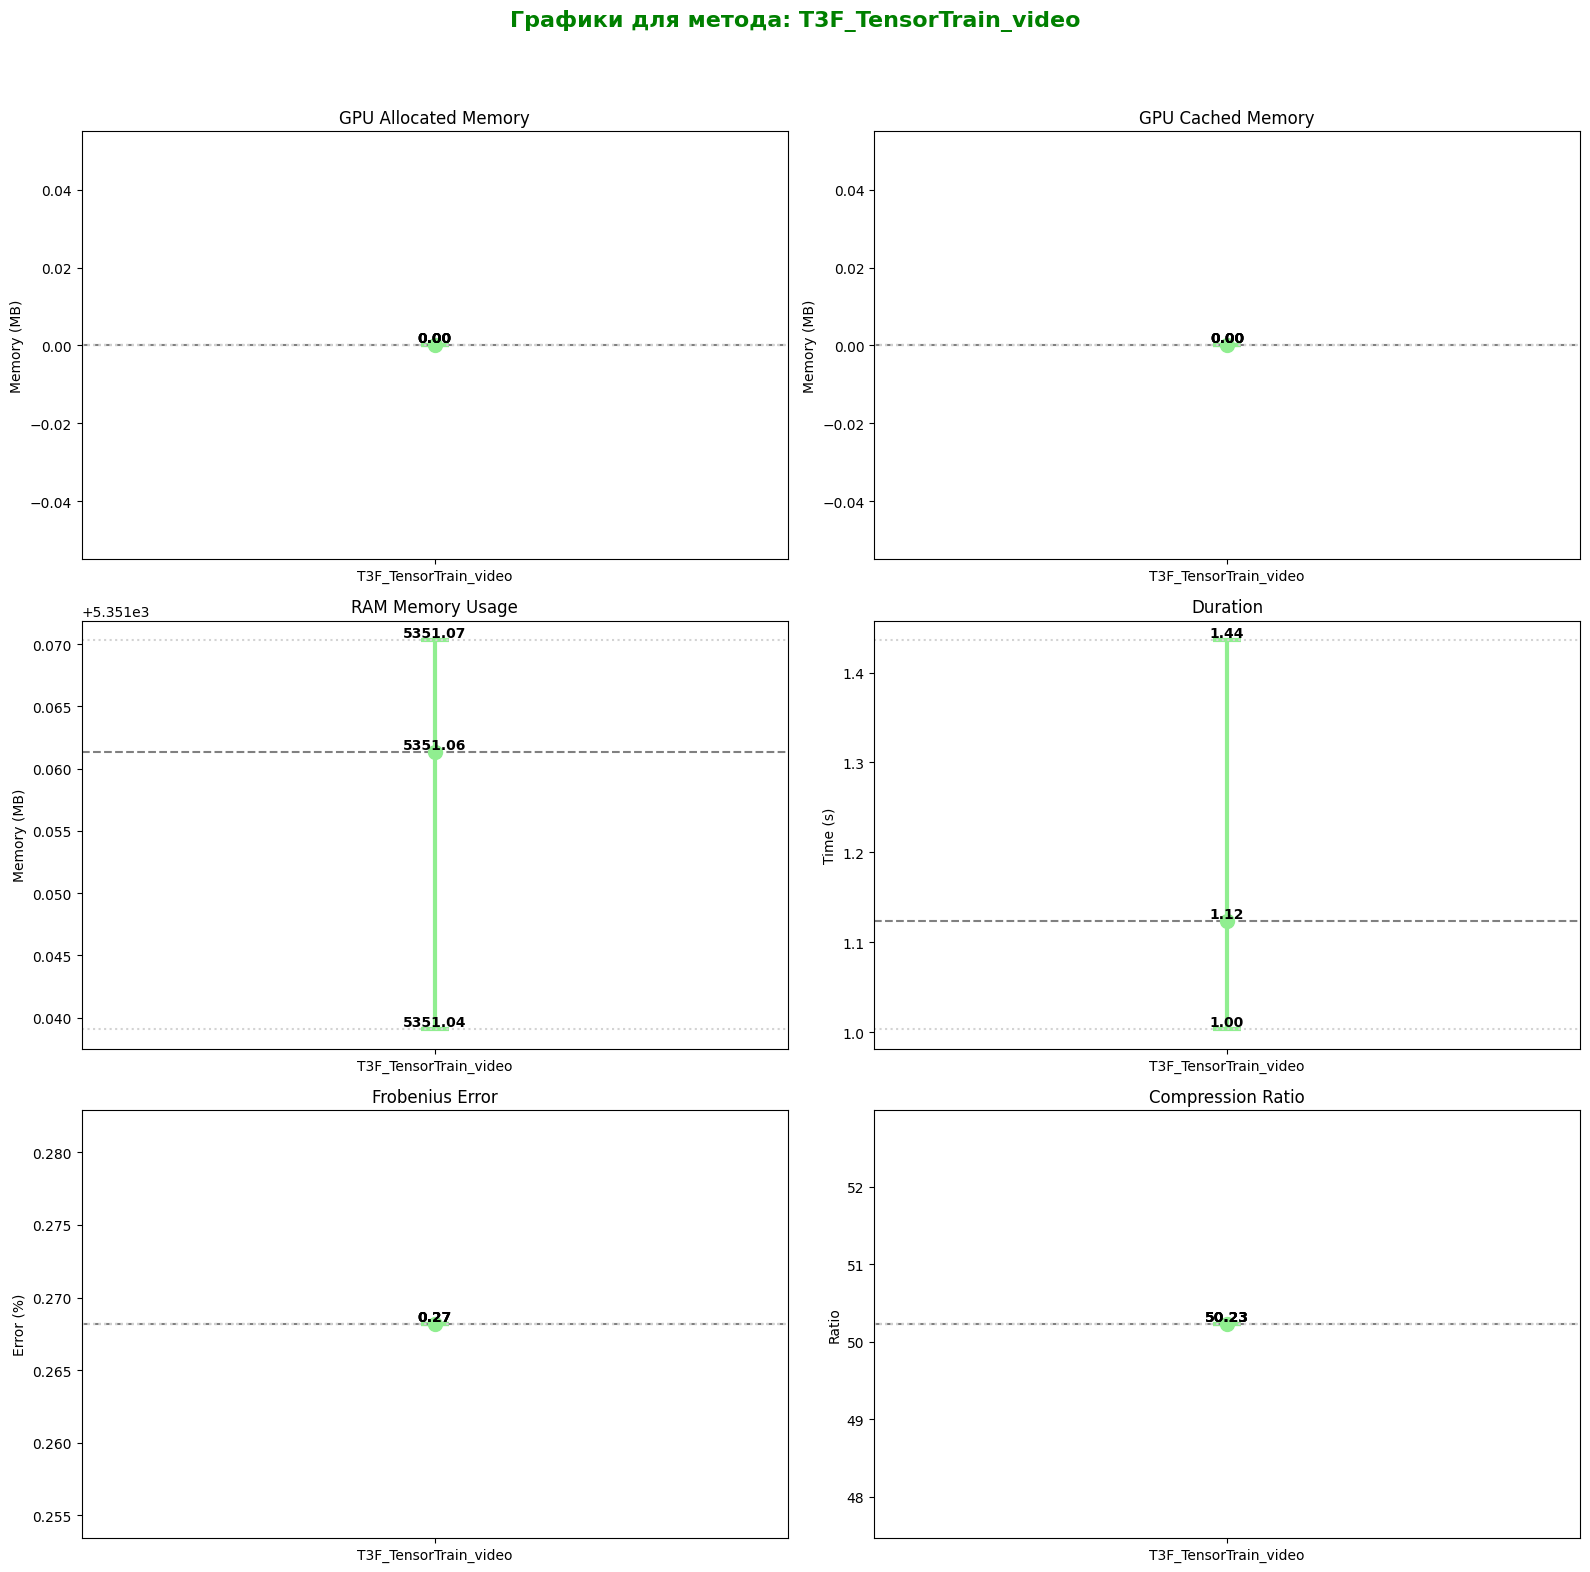

In [125]:
for method in methods:
    method_data = df_logs[df_logs["method_name"] == method]
    plot_error_bars(method_data, method)